# Info
Purpose:

    Describe the details ...

Input:

    arguments

Output:

    Figure and save files

Keywords:

    none

Dependencies:

    - load_utils.py
    - matplotlib
    - numpy
    - Sp_parameters
    - write_utils
    - path_utils
    - hdf5storage
    - scipy

Needed Files:
  - file.rc : for consistent creation of look of matplotlib figures
  - ...

Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2022-03-17
    Modified:


# Prepare python environment

In [1]:
import numpy as np
import Sp_parameters as Sp
import load_utils as lu
import plotting_utils as pu
import write_utils as wu
from path_utils import getpath
import hdf5storage as hs
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib notebook
import os
import glob

In [2]:
from datetime import datetime,timedelta
import scipy.stats as st
import pandas as pd
import plotting_utils as pu

In [3]:
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO, BytesIO
else:
    from io import StringIO, BytesIO

In [4]:
name = 'rooftop'
vv = 'v3'
fp = getpath(name)


Return path named:  rooftop /data/sunsat/rooftop/


# Load files

## Load 4STAR gas summary

In [5]:
if sys.version_info[0] < 3:
    import os, fnmatch
    def find_files(directory, pattern):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename
    files = list(find_files(fp+ '/gas_summary_v3/', '*gas_summary*.mat'))
else:
    files = glob.glob(fp + '/gas_summary_v3/**[!4STARB]*gas_summary*.mat', recursive=True)

In [6]:
files.sort()
files

['/data/sunsat/rooftop//gas_summary_v3/4STAR_20200624_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20200630_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20200701_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20200708_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20200805_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20200819_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20200824_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20200929_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20201001_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20201006_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20201027_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20201104_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20201112_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20210330_gas_summar

In [7]:
gas = {}
for f in files:
    g = sio.loadmat(f)
    daystr = f.replace('/','_').split('_')[-3]
    gas[daystr] = g

In [8]:
gas['20210330'].keys()

dict_keys(['__header__', '__version__', '__globals__', 'no2_molec_cm2', 'no2err_molec_cm2', 'no2DU', 'no2resiDU', 'o3DU', 'o3resiDU', 'hcoh_DU', 'hcohresi', 'cwv', 'cwv_std', 'lat', 'lon', 'alt', 'pst', 'sza', 'm_aero', 'm_o3', 'm_no2', 'tUTC'])

In [9]:
gas['20210330']['tUTC']

array([[15.47163194],
       [15.4721875 ],
       [15.47249111],
       ...,
       [22.16018639],
       [22.16074194],
       [22.16132361]])

In [10]:
kg = list(gas.keys())
kg.sort()

In [11]:
s = {'day':[],'time':[],'tUTC':[],'no2DU':[],'no2resiDU':[],'o3DU':[],'o3resiDU':[]}
for d in kg:
    for kk in ['tUTC','no2DU','no2resiDU','o3DU','o3resiDU']:
        s[kk] = np.append(s[kk],gas[d][kk][:,0])
    s['day'] = np.append(s['day'],[d]*len(gas[d][kk][:,0]))
    gas[d]['time'] = pd.to_datetime([d]*len(gas[d]['tUTC'][:,0])).to_numpy() + \
                                  [np.timedelta64(timedelta(hours=tt)) for tt in gas[d]['tUTC'][:,0]]

In [12]:
s['time'] = pd.to_datetime(s['day']).to_numpy() + [np.timedelta64(timedelta(hours=tt)) for tt in s['tUTC']]

In [13]:
s['time']

array(['2020-06-24T16:29:36.670998000', '2020-06-24T16:29:38.687000000',
       '2020-06-24T16:29:39.780999000', ...,
       '2022-04-24T23:08:44.967997000', '2022-04-24T23:08:46.967996000',
       '2022-04-24T23:08:48.967995000'], dtype='datetime64[ns]')

### Filter out bad data and back interpolate for easier handling

In [14]:
ibad = (s['no2DU']<0.005) | (s['no2DU']>1.0) | (s['no2resiDU']>0.00005)

In [15]:
s.keys()

dict_keys(['day', 'time', 'tUTC', 'no2DU', 'no2resiDU', 'o3DU', 'o3resiDU'])

In [16]:
from Sp_parameters import smooth

In [17]:
s['no2DU'][ibad] = np.nan

In [18]:
s_no2DU = smooth(s['no2DU'],1,nan=True,old=True)

<IPython.core.display.Javascript object>


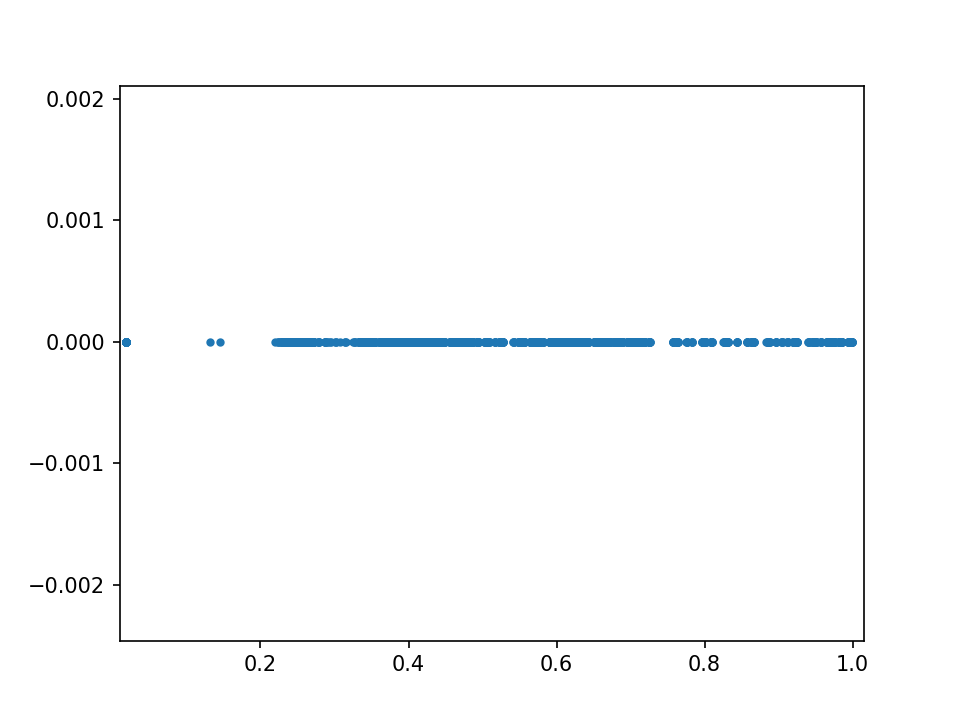

In [21]:
plt.figure()
plt.plot(s['no2DU'],s['no2resiDU'],'.')

<IPython.core.display.Javascript object>


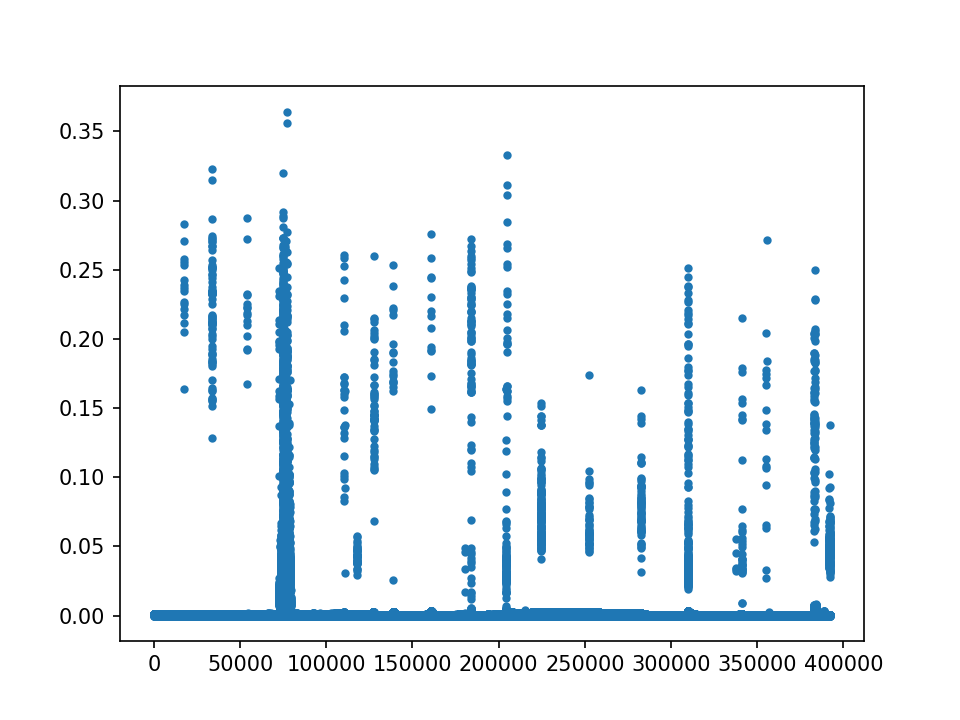

In [22]:
plt.figure()
plt.plot(s['no2resiDU'],'.')

<IPython.core.display.Javascript object>


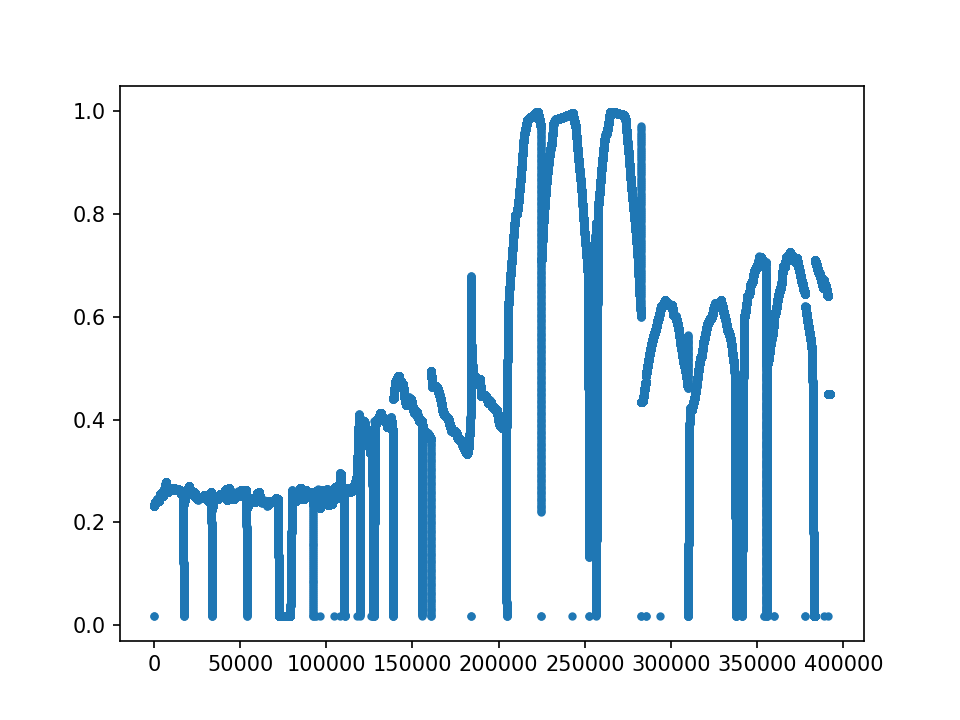

In [23]:
plt.figure()
plt.plot(s_no2DU,'.')

### Load previous 4STAR analysis

In [22]:
files2 = glob.glob(fp + '/gas_summary_v1*/**/[!4STARB]*gas_summary*.mat', recursive=True)
files2.sort()
files2

['/data/sunsat/rooftop/gas_summary_v1_pre2022/20190821_gas_summary.mat',
 '/data/sunsat/rooftop/gas_summary_v1_pre2022/20200623_gas_summary.mat',
 '/data/sunsat/rooftop/gas_summary_v1_pre2022/20200624_gas_summary.mat',
 '/data/sunsat/rooftop/gas_summary_v1_pre2022/20200630_gas_summary.mat',
 '/data/sunsat/rooftop/gas_summary_v1_pre2022/20200701_gas_summary.mat',
 '/data/sunsat/rooftop/gas_summary_v1_pre2022/20200708_gas_summary.mat',
 '/data/sunsat/rooftop/gas_summary_v1_pre2022/20200819_gas_summary.mat',
 '/data/sunsat/rooftop/gas_summary_v1_pre2022/20200918_gas_summary.mat',
 '/data/sunsat/rooftop/gas_summary_v1_pre2022/20200929_gas_summary.mat',
 '/data/sunsat/rooftop/gas_summary_v1_pre2022/20201001_gas_summary.mat',
 '/data/sunsat/rooftop/gas_summary_v1_pre2022/20201006_gas_summary.mat',
 '/data/sunsat/rooftop/gas_summary_v1_pre2022/20201027_gas_summary.mat',
 '/data/sunsat/rooftop/gas_summary_v1_pre2022/20201104_gas_summary.mat',
 '/data/sunsat/rooftop/gas_summary_v1_pre2022/20201

In [23]:
gas2 = {}
for f in files2:
    g2 = sio.loadmat(f)
    daystr = f.replace('/','_').split('_')[-3]
    gas2[daystr] = g2

In [24]:
s2 = {'day':[],'time':[],'tUTC':[],'no2DU':[],'no2resiDU':[],'o3DU':[],'o3resiDU':[]}
kg = list(gas2.keys())
kg.sort()
for d in kg:
    for kk in ['tUTC','no2DU','no2resiDU','o3DU','o3resiDU']:
        s2[kk] = np.append(s2[kk],gas2[d][kk][:,0])
    s2['day'] = np.append(s2['day'],[d]*len(gas2[d][kk][:,0]))

In [25]:
s2['time'] = pd.to_datetime(s2['day']).to_numpy() + [np.timedelta64(timedelta(hours=tt)) for tt in s2['tUTC']]

## Load Pandora

### load files from internet

In [24]:
import requests

In [25]:
url_base = 'http://data.pandonia-global-network.org/MountainViewCA/Pandora34s1/L2/'
url_O3 = url_base+'Pandora34s1_MountainViewCA_L2Tot_rout0p1-7.txt'
url_NO2 = url_base+'Pandora34s1_MountainViewCA_L2Tot_rnvs1p1-7.txt'
url_NO2_trop = url_base+'Pandora34s1_MountainViewCA_L2Trop_rnvh1p1-7.txt'

In [26]:
ro3 = requests.get(url_O3,stream=True)
fo3 = []
for chunk in ro3.iter_content(chunk_size=1024): 
    fo3.append(chunk)

In [27]:
rno2 = requests.get(url_NO2,stream=True)
fno2 = []
for chunk in rno2.iter_content(chunk_size=1024): 
    fno2.append(chunk)

### convert files to something easier to handle

#### Ozone

In [28]:
o3data = BytesIO(b''.join(fo3))

In [29]:
o3data.seek(0)
o3header = []
for i in range(66):
    o3header.append(o3data.readline())
print(*o3header,sep='\n')

b'File name: Pandora34s1_MountainViewCA_L2Tot_rout0p1-7.txt\n'
b'File generation date: 20220919T080948Z\n'
b'Data description: Level 2 total columns file\n'
b'Data file version: rout0p1-7\n'
b'Data product status: Ozone data are official, Sulfur dioxide data are unusable\n'
b'Local principal investigator: Nader Abuhassan\n'
b'Network principal investigator: Alexander Cede\n'
b'Instrument type: Pandora\n'
b'Instrument number: 34\n'
b'Spectrometer number: 1\n'
b'Processing software version used: BlickP v1.7.16\n'
b'Full location name: Ames Research Center\n'
b'Short location name: MountainViewCA\n'
b'Country of location: United States\n'
b'Location latitude [deg]: 37.4200\n'
b'Location longitude [deg]: -122.0568\n'
b'Location altitude [m]: 50\n'
b'Data start time: 20191121T221159Z\n'
b'Data end time: NONE\n'
b'Data caveats: None\n'
b'---------------------------------------------------------------------------------------\n'
b'Column 1: UT date and time for center of measurement, yyyymmddT

In [30]:
col_name = ['Time','doy_jan2000','duration_time','sza','saz','lza','laz','o3_du','unc_o3_du','m_o3','diff_corr','qa_o3','sumi2_dq1',
            'sumi_dq2','so2_du','unc_so2_du','m_so2','diff_corr_so2','qa_no2','sumi2_so2_dq1','sumi2_so2_dq2',
            'fit_resi','resi_rms','expmeas_resi_rms','expinst_resi_rms','mean_val','Pres_mbar','dat_proc',
            'cal_version','cal_val_date','L2fit_QA','sumi2_L2fit_dq1','sumi2_L2fit_dq2','L1_QA','sumi2_L1_dq1',
            'sumi2_L1_dq2','effT_wav','resi_straylight','L1_wv_shift','wv_shift_fit','int','darkcount','pos_filter1','pos_filter2']

In [31]:
col_name_decription = {}
j = 0
header_start = False
for i,h in enumerate(o3header):
    if h.strip().startswith(b'----'): 
        header_start = ~header_start
        continue
    if header_start:
        print(j,'\033[1m'+col_name[j]+'\033[0m',h)
        col_name_decription[col_name[j]] = h
        j = j+1

0 Time b'Column 1: UT date and time for center of measurement, yyyymmddThhmmssZ (ISO 8601)\n'
1 doy_jan2000 b'Column 2: Fractional days since 1-Jan-2000 UT midnight for center of measurement\n'
2 duration_time b'Column 3: Effective duration of measurement in seconds\n'
3 sza b'Column 4: Solar zenith angle for center of measurement in degree\n'
4 saz b'Column 5: Solar azimuth for center of measurement in degree, 0=north, increases clockwise\n'
5 lza b'Column 6: Lunar zenith angle for center of measurement in degree\n'
6 laz b'Column 7: Lunar azimuth for center of measurement in degree, 0=north, increases clockwise\n'
7 o3_du b'Column 8: Ozone total vertical column amount [Dobson Units], -9e99=retrieval not successful\n'
8 unc_o3_du b'Column 9: Uncertainty of ozone total vertical column amount [Dobson Units] based on measured uncertainty, -8=retrieval not successful, -1=cross section is zero in this wavelength range, -3=spectral fitting was done, but no uncertainty could be retrieved\n'


In [32]:
o3data.seek(0)
pdo3 = pd.read_csv(o3data,encoding='unicode_escape',header=66,delimiter=' ',names=col_name)

In [33]:
pdo3

Time  doy_jan2000  duration_time    sza     saz    lza  \
0         20191121T221326Z   7264.92600          26.09  66.12  215.93  89.91   
1         20191121T221453Z   7264.92701          26.62  66.29  216.25  90.19   
2         20191121T221618Z   7264.92800          25.86  66.46  216.57  90.47   
3         20191121T222329Z   7264.93298          26.80  67.33  218.14  91.85   
4         20191121T222455Z   7264.93398          27.79  67.50  218.46  92.12   
...                    ...          ...            ...    ...     ...    ...   
146052  20220918T224631.1Z   8296.94897           0.95  52.03  236.43  94.67   
146053  20220918T225105.1Z   8296.95214          51.47  52.79  237.50  95.34   
146054  20220918T225617.9Z   8296.95576          51.45  53.67  238.70  96.11   
146055  20220918T230112.3Z   8296.95917          51.64  54.51  239.80  96.82   
146056  20220918T230632.2Z   8296.96287          50.09  55.43  240.98  97.58   

           laz   o3_du  unc_o3_du   m_o3  ...  sumi2_L1_dq1  sumi2_L1_dq2  \
0       276.83  293.36    0.11227  2.428  ...             0             0   
1       277.04  293.04    0.11232  2.444  ...             0             0   
2       277.24  292.97    0.11349  2.460  ...             0             0   
3       278.27  292.34    0.11513  2.544  ...             0             0   
4       278.48  292.33    0.11538  2.563  ...             0             0   
...        ...     ...        ...    ...  ...           ...           ...   
146052  309.03  302.81    5.90890  1.616  ...             1             1   
146053  309.74  301.90    2.19110  1.644  ...             0             0   
146054  310.55  301.85    0.20172  1.677  ...             0             0   
146055  311.33  301.88    0.76768  1.711  ...             0             0   
146056  312.19  301.40   40.69300  1.750  ...             0             0   

        effT_wav  resi_straylight  L1_wv_shift  wv_shift_fit    int  \
0          25.68             0.23     -0.01140      -0.04927   20.9   
1          25.68             0.25     -0.01147      -0.04921   21.2   
2          25.68             0.23     -0.01111      -0.04953   21.5   
3          25.68             0.25     -0.01178      -0.05119   22.6   
4          25.68             0.24     -0.01158      -0.05101   22.7   
...          ...              ...          ...           ...    ...   
146052     27.05             0.22     -0.00300      -0.01846   17.6   
146053     27.05             0.25     -0.00321      -0.02034   13.3   
146054     27.05             0.24     -0.00240      -0.02717   12.1   
146055     27.05             0.24     -0.00306      -0.02063   11.8   
146056     27.05             0.27     -0.01478      -0.01120  117.3   

        darkcount  pos_filter1  pos_filter2  
0             237            1            5  
1             234            1            5  
2             232            1            5  
3             223            1            5  
4             222            1            5  
...           ...          ...          ...  
146052        547            1            5  
146053        722            1            5  
146054        796            1            5  
146055        812            1            5  
146056         83            1            5  

[146057 rows x 44 columns]

In [34]:
pdo3['datetime'] = pd.to_datetime(pdo3['Time'])

#### NO2

In [35]:
no2data = BytesIO(b''.join(fno2))

In [36]:
no2data.seek(0)
no2header = []
for i in range(59):
    no2header.append(no2data.readline())
print(*no2header,sep='\n')

b'File name: Pandora34s1_MountainViewCA_L2Tot_rnvs1p1-7.txt\n'
b'File generation date: 20220919T080948Z\n'
b'Data description: Level 2 total columns file\n'
b'Data file version: rnvs1p1-7\n'
b'Data product status: Nitrogen dioxide data are official\n'
b'Local principal investigator: Nader Abuhassan\n'
b'Network principal investigator: Alexander Cede\n'
b'Instrument type: Pandora\n'
b'Instrument number: 34\n'
b'Spectrometer number: 1\n'
b'Processing software version used: BlickP v1.7.16\n'
b'Full location name: Ames Research Center\n'
b'Short location name: MountainViewCA\n'
b'Country of location: United States\n'
b'Location latitude [deg]: 37.4200\n'
b'Location longitude [deg]: -122.0568\n'
b'Location altitude [m]: 50\n'
b'Data start time: 20191121T221109Z\n'
b'Data end time: NONE\n'
b'Data caveats: None\n'
b'---------------------------------------------------------------------------------------\n'
b'Column 1: UT date and time for center of measurement, yyyymmddThhmmssZ (ISO 8601)\n'
b

In [37]:
col_name_no2 = ['Time','doy_jan2000','duration_time','sza','saz','lza','laz',
                'no2_du','unc_no2_du','m_no2','diff_corr_no2','qa_no2','sumi2_no2_dq1','sumi_no2_dq2',
                'fit_resi','resi_rms','expmeas_resi_rms','expinst_resi_rms','mean_val','Pres_mbar','dat_proc',
            'cal_version','cal_val_date','L2fit_QA','sumi2_L2fit_dq1','sumi2_L2fit_dq2','L1_QA','sumi2_L1_dq1',
            'sumi2_L1_dq2','effT_wav','resi_straylight','L1_wv_shift','wv_shift_fit','int','darkcount','pos_filter1','pos_filter2']

In [38]:
col_name_no2_decription = {}
j = 0
header_start = False
for i,h in enumerate(no2header):
    if h.strip().startswith(b'----'): 
        header_start = ~header_start
        continue
    if header_start:
        print(j,'\033[1m'+col_name_no2[j]+'\033[0m',h)
        col_name_no2_decription[col_name_no2[j]] = h
        j = j+1

0 Time b'Column 1: UT date and time for center of measurement, yyyymmddThhmmssZ (ISO 8601)\n'
1 doy_jan2000 b'Column 2: Fractional days since 1-Jan-2000 UT midnight for center of measurement\n'
2 duration_time b'Column 3: Effective duration of measurement in seconds\n'
3 sza b'Column 4: Solar zenith angle for center of measurement in degree\n'
4 saz b'Column 5: Solar azimuth for center of measurement in degree, 0=north, increases clockwise\n'
5 lza b'Column 6: Lunar zenith angle for center of measurement in degree\n'
6 laz b'Column 7: Lunar azimuth for center of measurement in degree, 0=north, increases clockwise\n'
7 no2_du b'Column 8: Nitrogen dioxide total vertical column amount [Dobson Units], -9e99=retrieval not successful\n'
8 unc_no2_du b'Column 9: Uncertainty of nitrogen dioxide total vertical column amount [Dobson Units] based on measured uncertainty, -8=retrieval not successful, -1=cross section is zero in this wavelength range, -3=spectral fitting was done, but no uncertaint

In [39]:
no2data.seek(0)
pdno2 = pd.read_csv(no2data,encoding='unicode_escape',header=59,delimiter=' ',names=col_name_no2)

In [40]:
pdno2['datetime'] = pd.to_datetime(pdno2['Time'])

In [41]:
pdno2

Time  doy_jan2000  duration_time    sza     saz    lza  \
0         20191121T221239Z   7264.92546          19.47  66.03  215.76  89.76   
1         20191121T221407Z   7264.92648          21.01  66.20  216.08  90.05   
2         20191121T221532Z   7264.92746          19.35  66.37  216.40  90.32   
3         20191121T221659Z   7264.92847          20.78  66.54  216.72  90.60   
4         20191121T222242Z   7264.93244          19.78  67.23  217.97  91.70   
...                    ...          ...            ...    ...     ...    ...   
566916  20220918T230230.8Z   8296.96008           5.72  54.73  240.10  97.00   
566917  20220918T230236.8Z   8296.96015           5.79  54.75  240.12  97.02   
566918  20220918T230242.9Z   8296.96022           5.74  54.76  240.14  97.03   
566919  20220918T230249.0Z   8296.96029           5.77  54.78  240.16  97.05   
566920  20220918T230721.2Z   8296.96344          19.05  55.57  241.16  97.69   

           laz   no2_du  unc_no2_du  m_no2  ...  sumi2_L1_dq2  effT_wav  \
0       276.72  0.44002    0.000918  2.444  ...             0     25.68   
1       276.93  0.44762    0.000932  2.461  ...             0     25.68   
2       277.13  0.43500    0.000917  2.477  ...             0     25.68   
3       277.34  0.44617    0.000913  2.493  ...             2     25.68   
4       278.16  0.44165    0.000996  2.564  ...             0     25.68   
...        ...      ...         ...    ...  ...           ...       ...   
566916  311.54  0.13065    0.034401  1.727  ...             0     27.05   
566917  311.56  0.12755    0.017333  1.728  ...             0     27.05   
566918  311.58  0.13328    0.022235  1.729  ...             0     27.05   
566919  311.59  0.12431    0.036431  1.729  ...             0     27.05   
566920  312.32  0.13786    0.673170  1.763  ...             1     27.05   

        resi_straylight  L1_wv_shift  wv_shift_fit    int  darkcount  \
0                  1.00     -0.00199      -0.00149    8.4        433   
1                  1.00     -0.00151      -0.00081    8.5        429   
2                  1.00     -0.00142      -0.00097    8.5        429   
3                  0.93     -0.00136      -0.00088    8.6          0   
4                  1.00     -0.00140      -0.00117    8.7        424   
...                 ...          ...           ...    ...        ...   
566916             1.02     -0.00203      -0.00297    3.2        335   
566917             1.02     -0.00238      -0.00337    3.2        335   
566918             1.02     -0.00232      -0.00342    3.2        335   
566919             1.02     -0.00117      -0.00259    3.2        335   
566920             0.98     -0.00204      -0.00263  165.5         59   

        pos_filter1  pos_filter2                         datetime  
0                 3            4        2019-11-21 22:12:39+00:00  
1                 3            4        2019-11-21 22:14:07+00:00  
2                 3            4        2019-11-21 22:15:32+00:00  
3                 3            4        2019-11-21 22:16:59+00:00  
4                 3            4        2019-11-21 22:22:42+00:00  
...             ...          ...                              ...  
566916            2            4 2022-09-18 23:02:30.800000+00:00  
566917            2            4 2022-09-18 23:02:36.800000+00:00  
566918            2            4 2022-09-18 23:02:42.900000+00:00  
566919            2            4        2022-09-18 23:02:49+00:00  
566920            1            4 2022-09-18 23:07:21.200000+00:00  

[566921 rows x 38 columns]

# Plot out data

## Plot time series

<IPython.core.display.Javascript object>


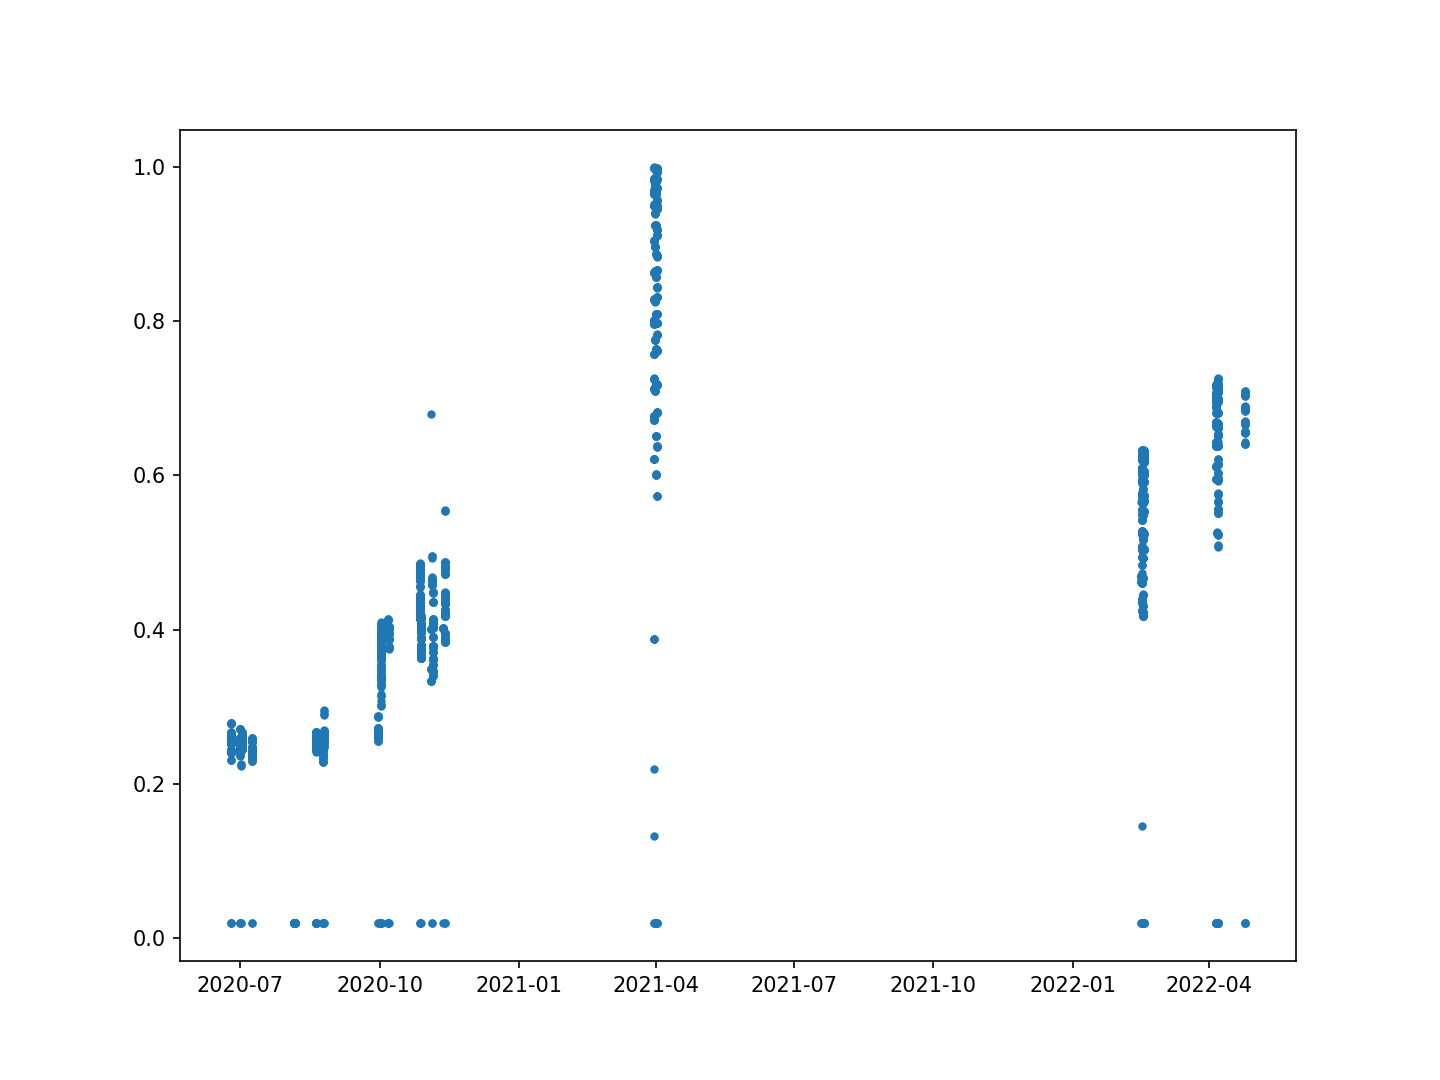

In [42]:
plt.figure()
plt.plot(s['time'],s['no2DU'],'.')

<IPython.core.display.Javascript object>


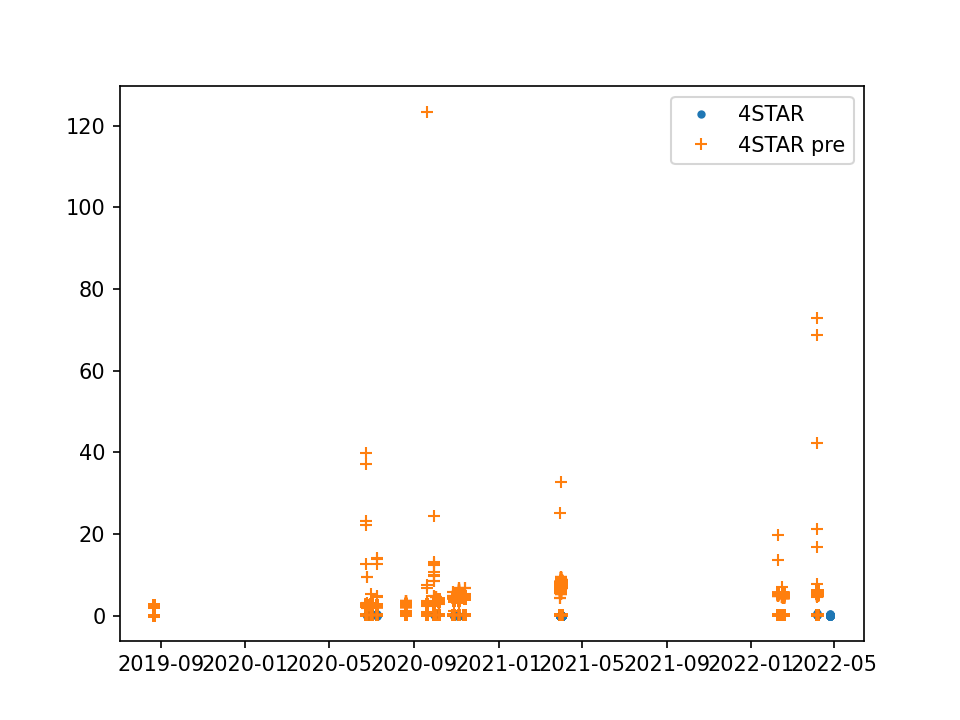

In [45]:
plt.figure()
plt.plot(s['time'],s['no2DU'],'.',label='4STAR')
plt.plot(s2['time'],s2['no2DU'],'+',label='4STAR pre')
plt.legend()

<IPython.core.display.Javascript object>


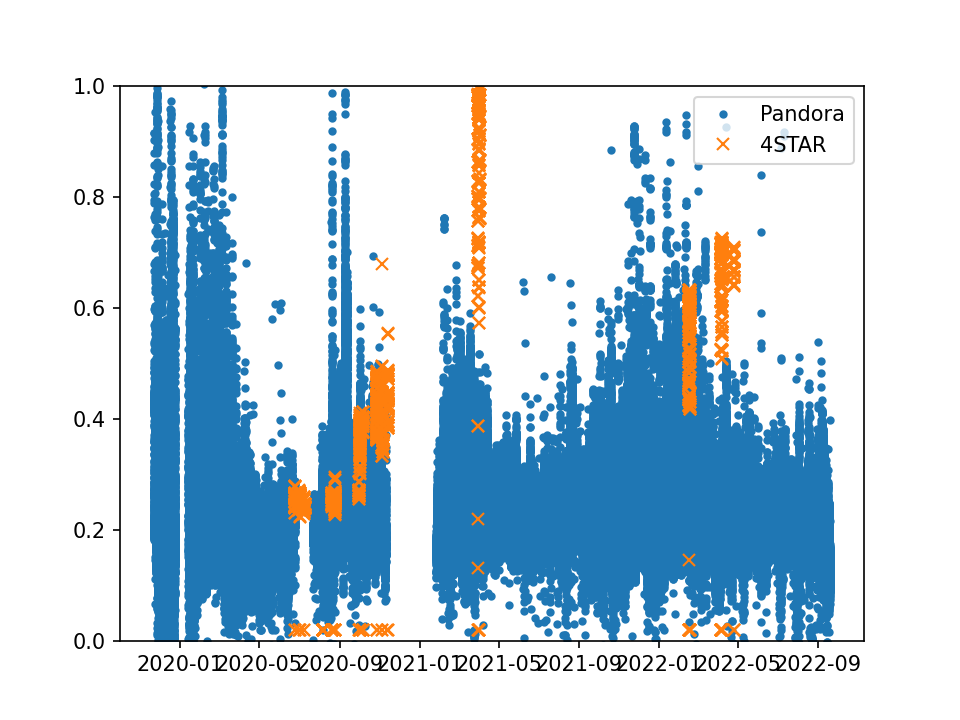

In [44]:
plt.figure()
plt.plot(pdno2['datetime'],pdno2['no2_du'],'.',label='Pandora')
plt.plot(s['time'],s['no2DU'],'x',label='4STAR')
plt.ylim(0,1)
plt.legend()

In [113]:
ddd = s['time'][0]

In [116]:
ddd -  datetime.datetime(2018,1,1)

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

<IPython.core.display.Javascript object>


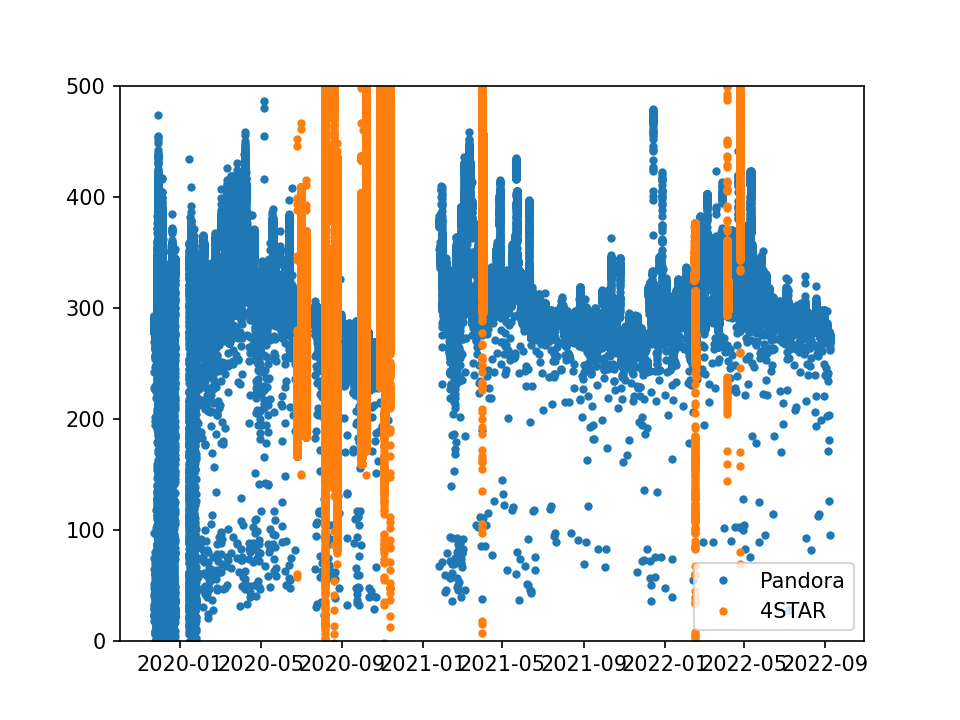

In [51]:
plt.figure()
plt.plot(pdo3['datetime'],pdo3['o3_du'],'.',label='Pandora')
plt.plot(s['time'],s['o3DU'],'.',label='4STAR')
plt.ylim(0,500)
plt.legend()

## Plot each day of measurement in new figure

In [45]:
def get_unixtime(dt64):
    return dt64.astype('datetime64[ms]').astype('float')/1000.0

In [46]:
unix_t = get_unixtime(s['time'])

In [47]:
days_since_2018 = (unix_t-get_unixtime(np.datetime64('2018-01-01T00:00:00.0')))/60.0/60.0/24.0

In [48]:
t0 = pdno2['datetime'].dt.tz_localize(None).to_numpy()

In [49]:
pandora_days_since_2018 = (get_unixtime(t0)-get_unixtime(np.datetime64('2018-01-01T00:00:00.0')))/60.0/60.0/24.0

In [50]:
meas_days = np.unique(days_since_2018.astype(int))

In [51]:
len(meas_days)

21

In [52]:
pdd = pdno2['datetime'][0]

In [53]:
print(pdd.date())

2019-11-21


In [57]:
meas_days

array([ 905,  911,  912,  919,  947,  961,  966, 1002, 1004, 1009, 1030,
       1038, 1046, 1184, 1185, 1186, 1506, 1507, 1555, 1556, 1574])

In [58]:
gas['20200624'].keys()

dict_keys(['__header__', '__version__', '__globals__', 'no2_molec_cm2', 'no2err_molec_cm2', 'no2DU', 'no2resiDU', 'o3DU', 'o3resiDU', 'hcoh_DU', 'hcohresi', 'cwv', 'cwv_std', 'lat', 'lon', 'alt', 'pst', 'sza', 'm_aero', 'm_o3', 'm_no2', 'tUTC', 'time'])

In [59]:
day_key = '20200624'
gas[day_key]['time'] = pd.to_datetime([day_key]*len(gas[day_key]['no2DU'][:,0])).to_numpy() +\
                                      [np.timedelta64(timedelta(hours=tt)) for tt in gas[day_key]['tUTC'][:,0]]

<IPython.core.display.Javascript object>


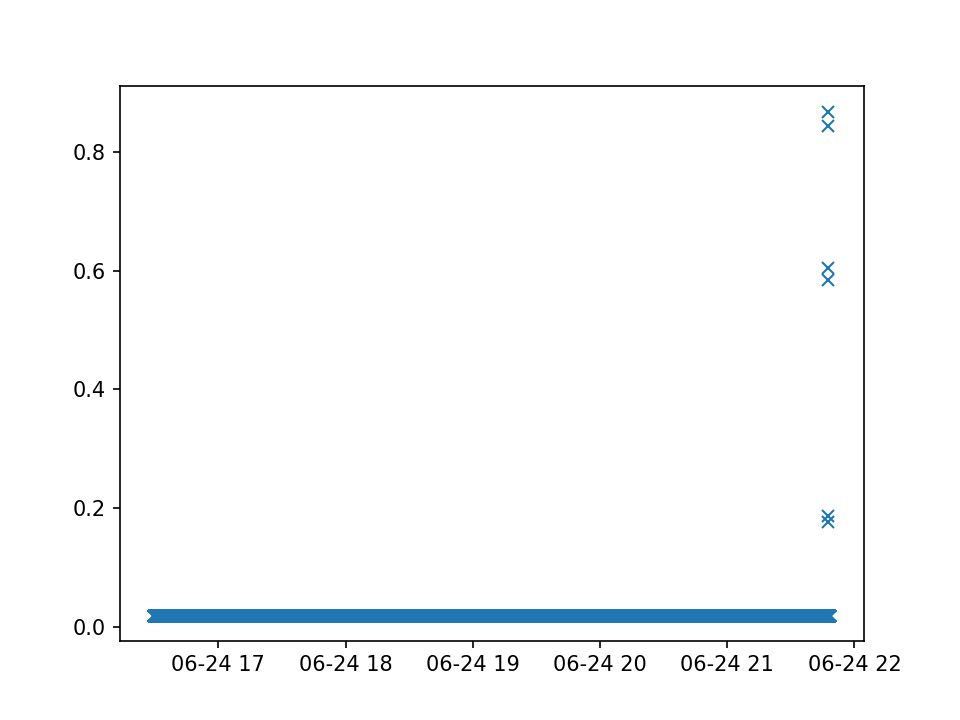

In [169]:
plt.figure()
plt.plot(gas['20200624']['time'],gas['20200624']['no2DU'],'x')

<IPython.core.display.Javascript object>


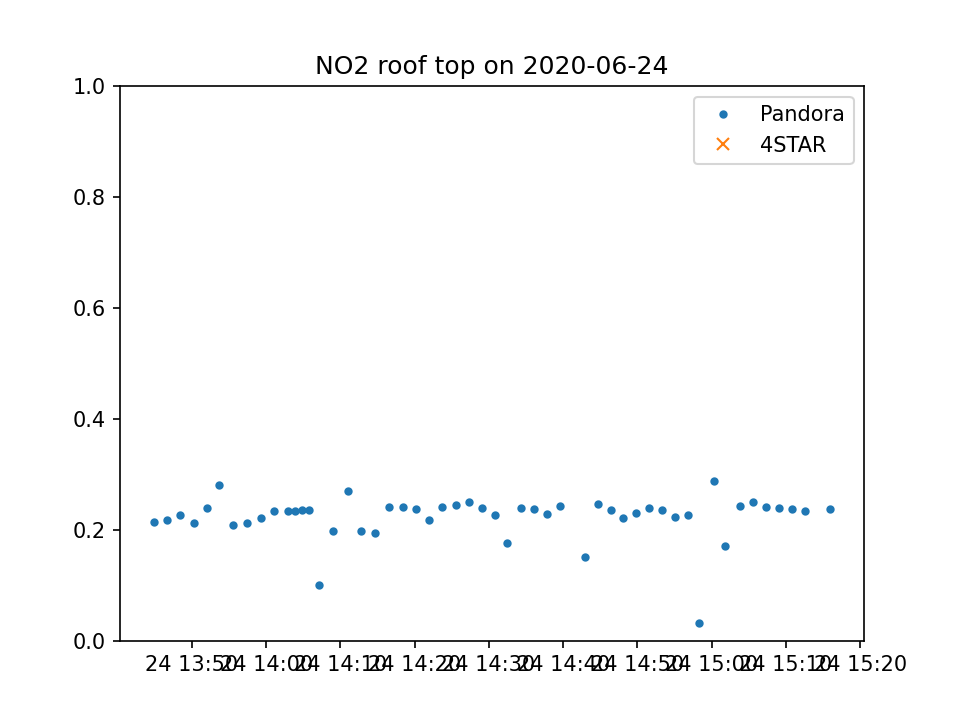

Text(0.5, 1.0, 'NO2 roof top on 2020-06-24')

In [178]:
day = 905
plt.figure()
ip = pandora_days_since_2018.astype(int) == day
iss = days_since_2018.astype(int) == day
plt.plot(pdno2['datetime'][ip],pdno2['no2_du'][ip],'.',label='Pandora')
plt.plot(s['time'][iss],s['no2DU'][iss],'x',label='4STAR')
plt.ylim(0,1)
plt.legend()
plt.title('NO2 roof top on {}'.format(pdno2['datetime'][ip].iloc[0].date()))


In [159]:
s['no2DU'][iss][~np.isnan(s['no2DU'][iss])]

array([], dtype=float64)

<IPython.core.display.Javascript object>


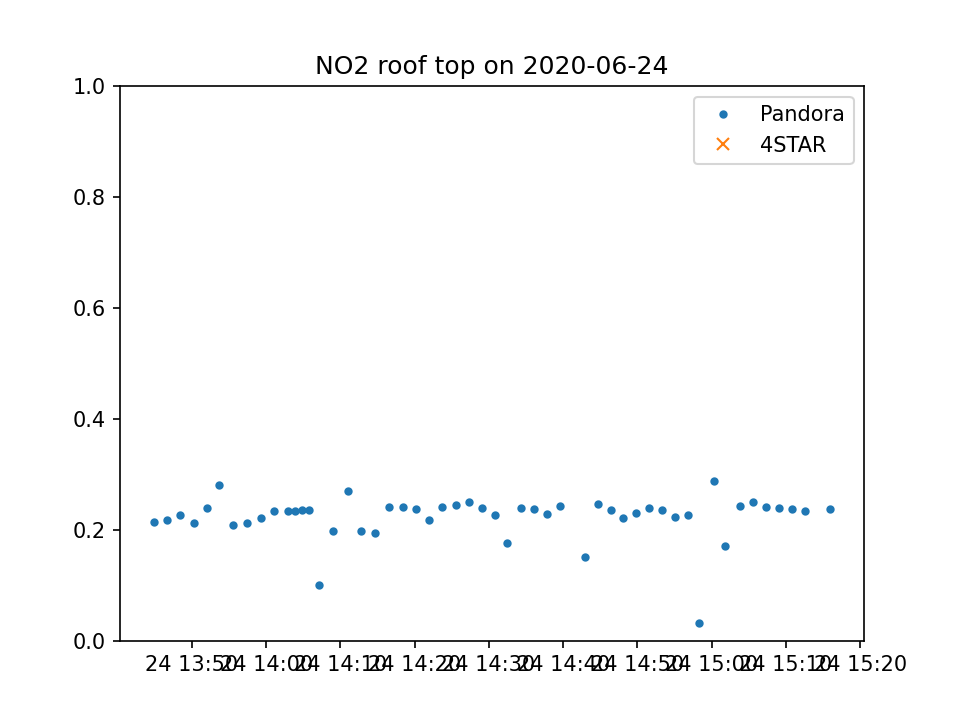

<IPython.core.display.Javascript object>


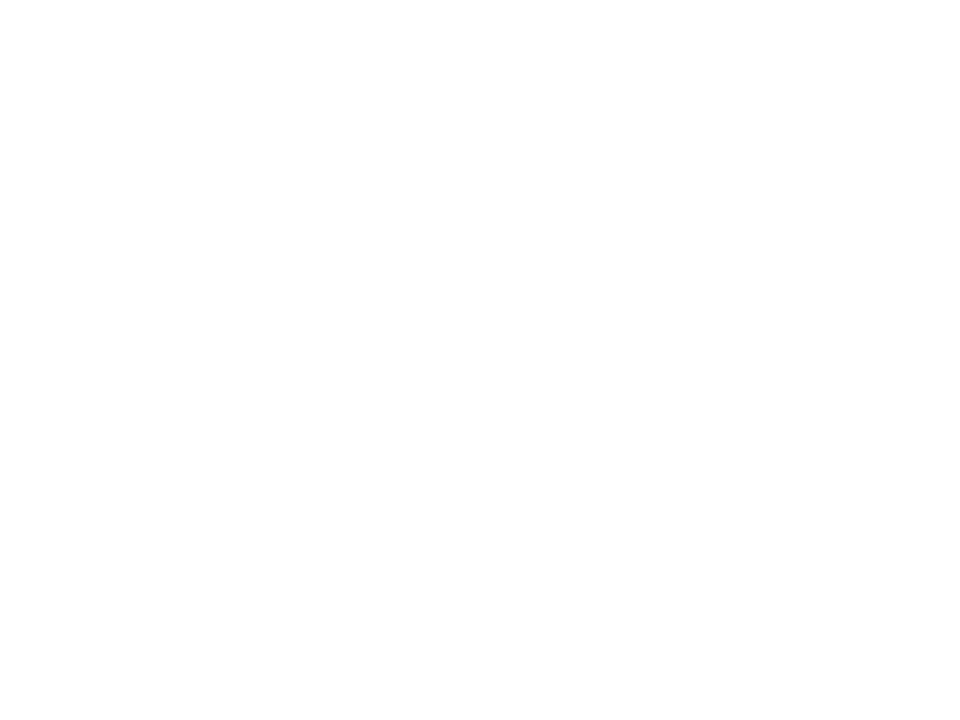

<IPython.core.display.Javascript object>


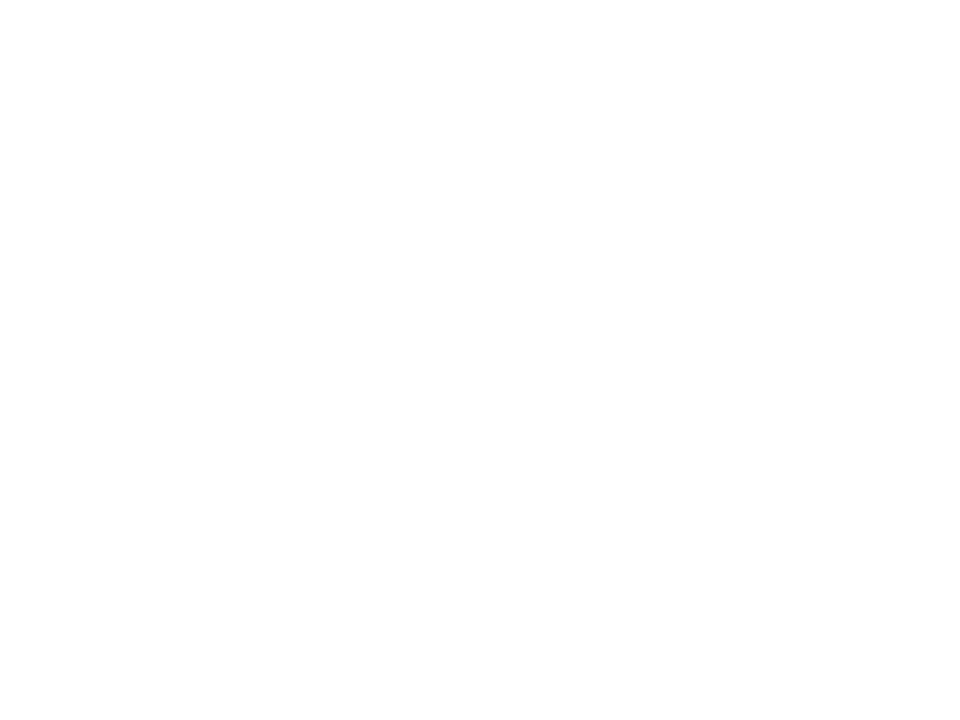

<IPython.core.display.Javascript object>


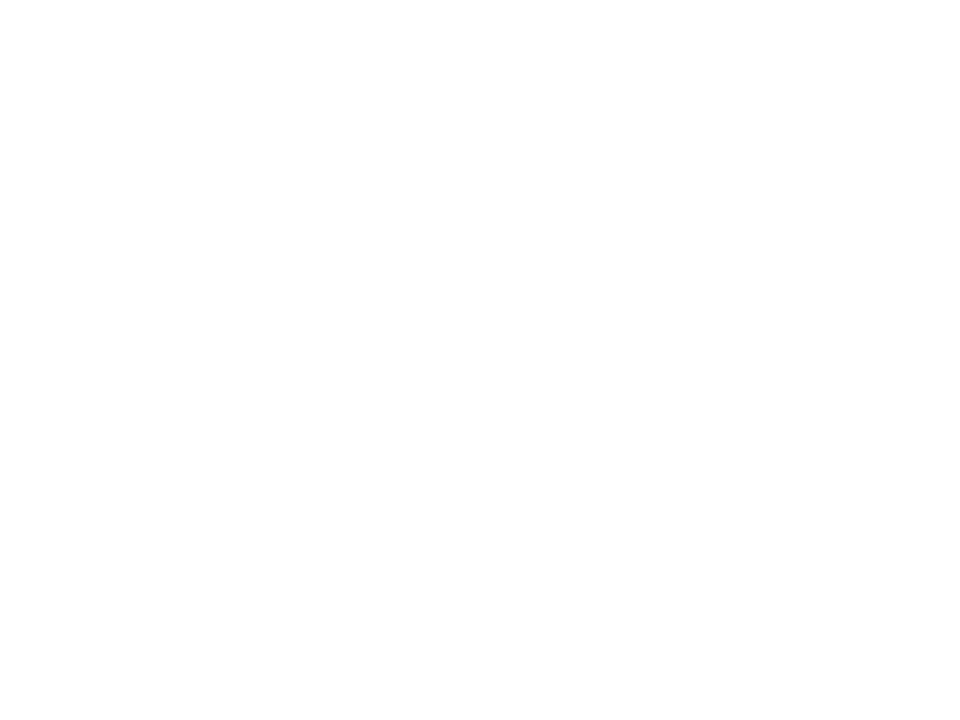

<IPython.core.display.Javascript object>


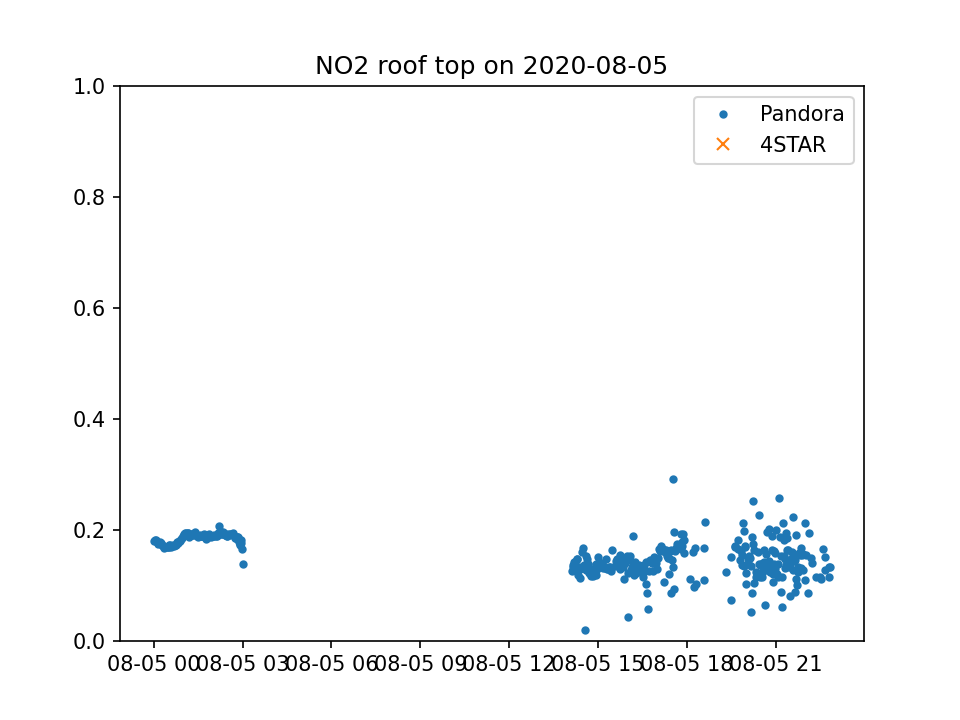

<IPython.core.display.Javascript object>


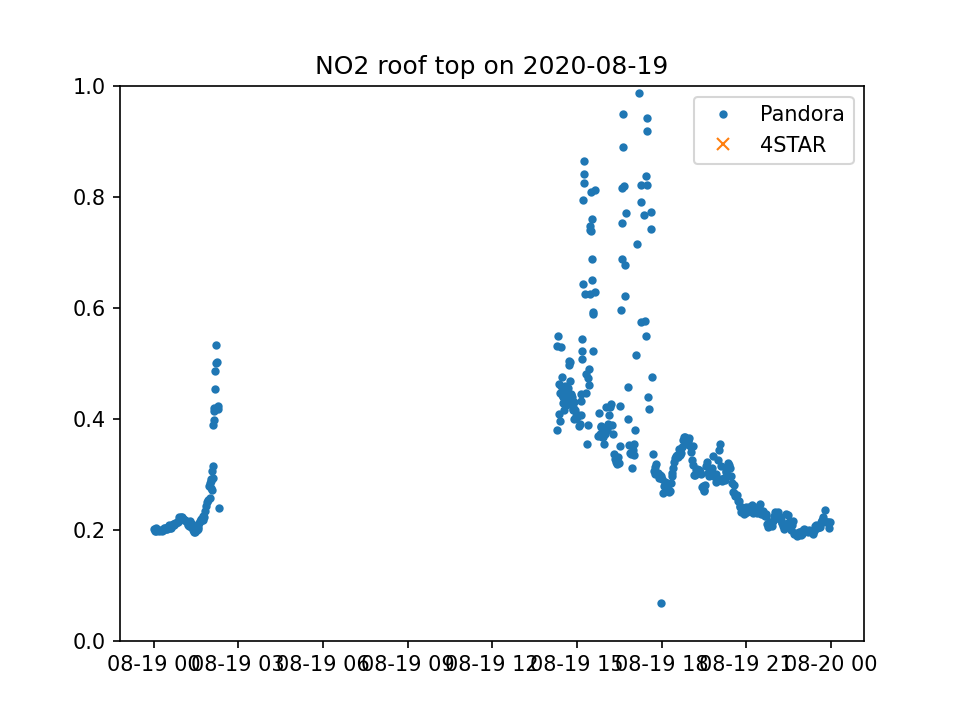

<IPython.core.display.Javascript object>


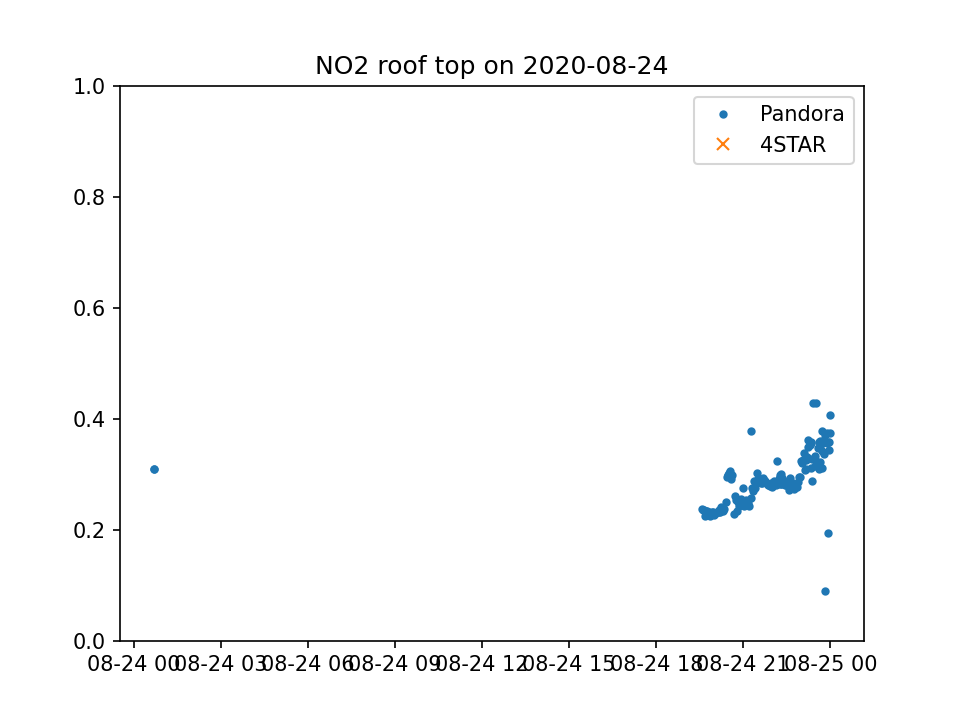

<IPython.core.display.Javascript object>


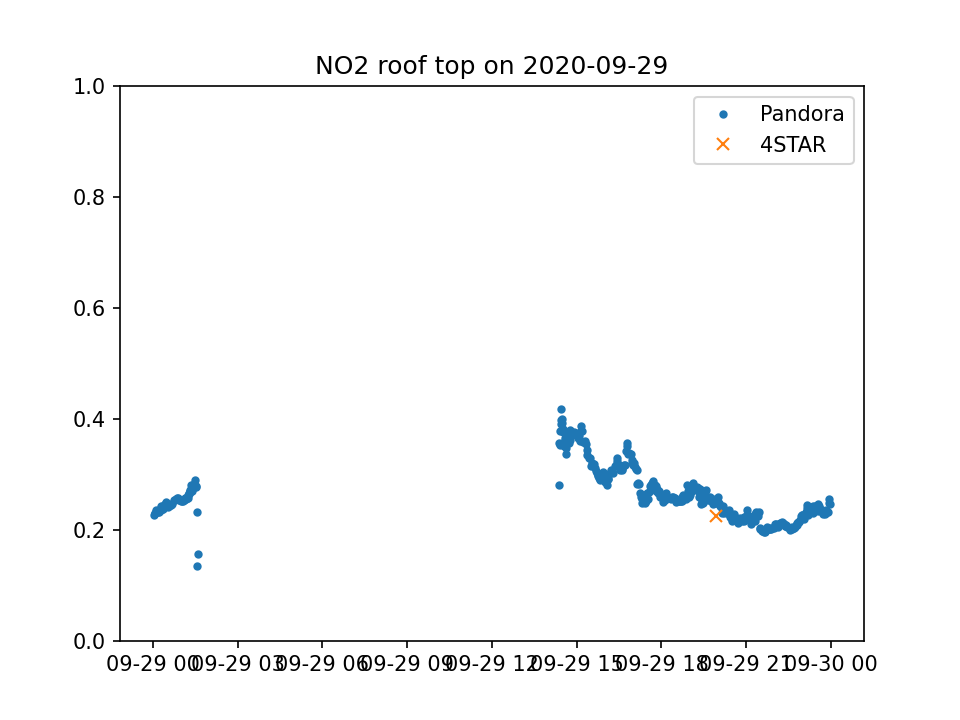

<IPython.core.display.Javascript object>


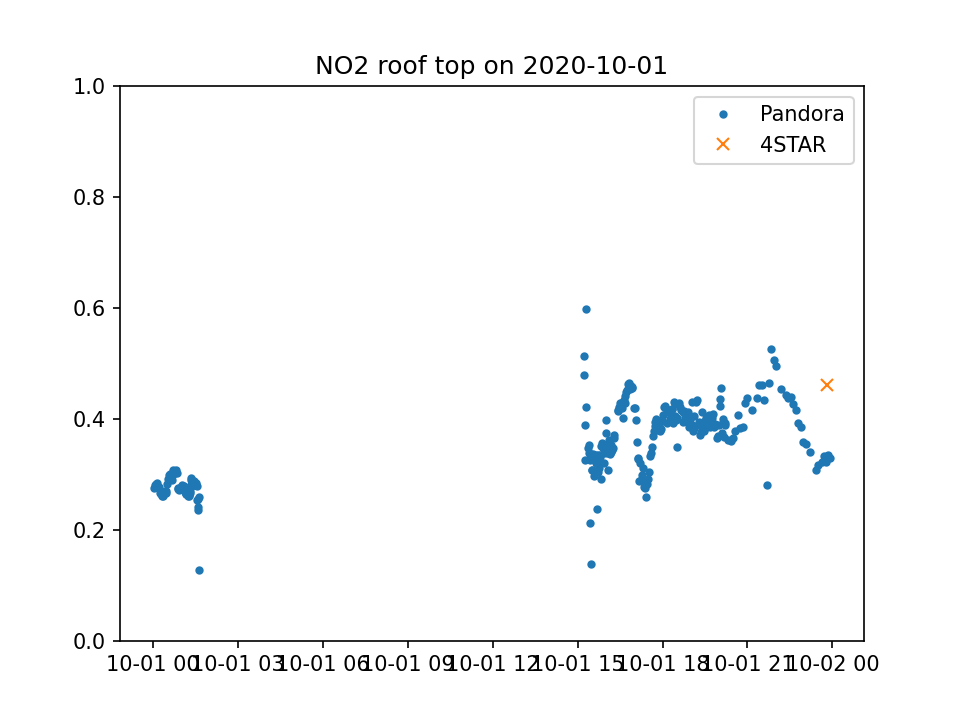

<IPython.core.display.Javascript object>


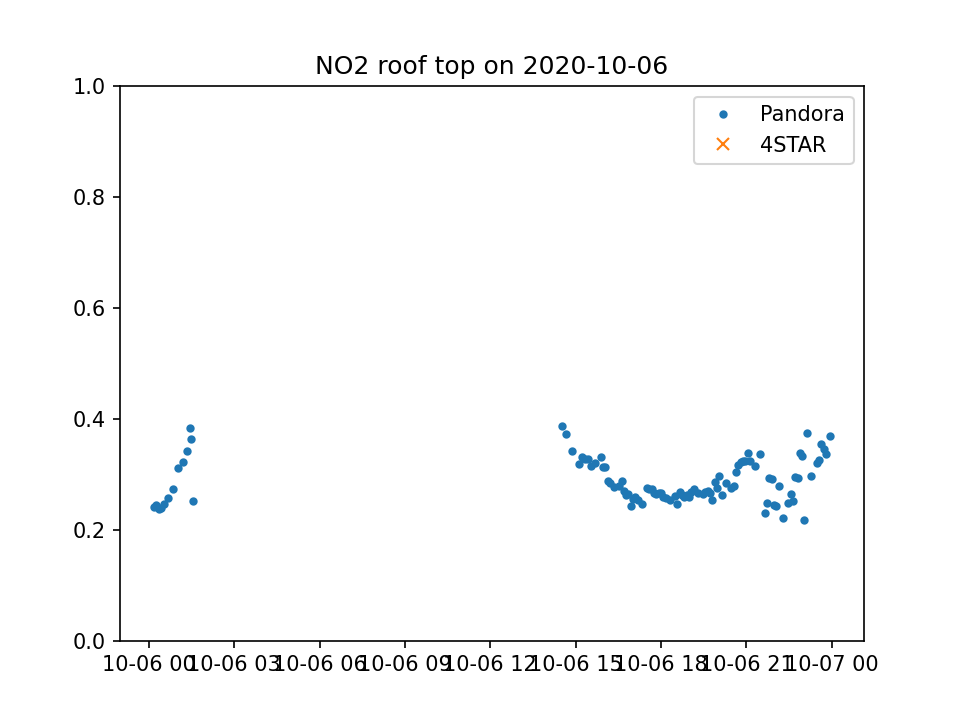

<IPython.core.display.Javascript object>


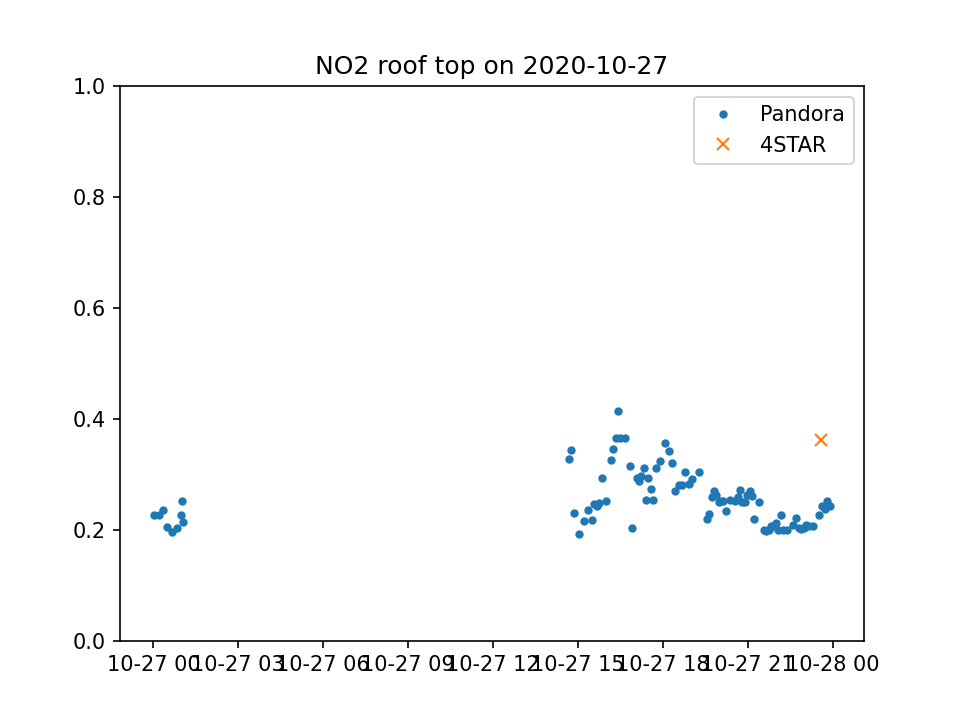

<IPython.core.display.Javascript object>


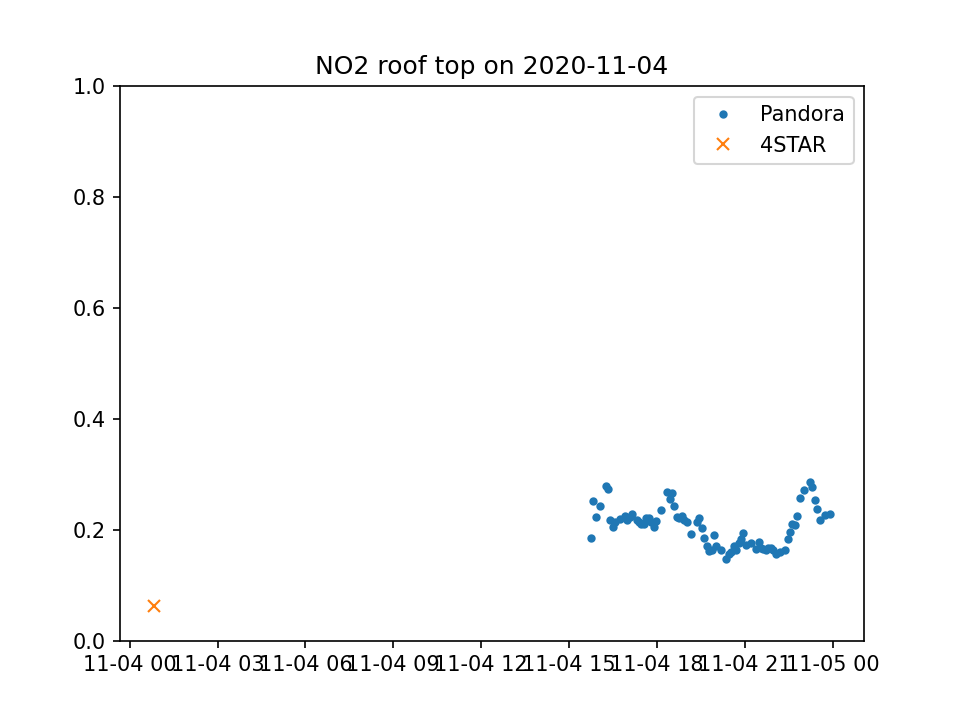

<IPython.core.display.Javascript object>


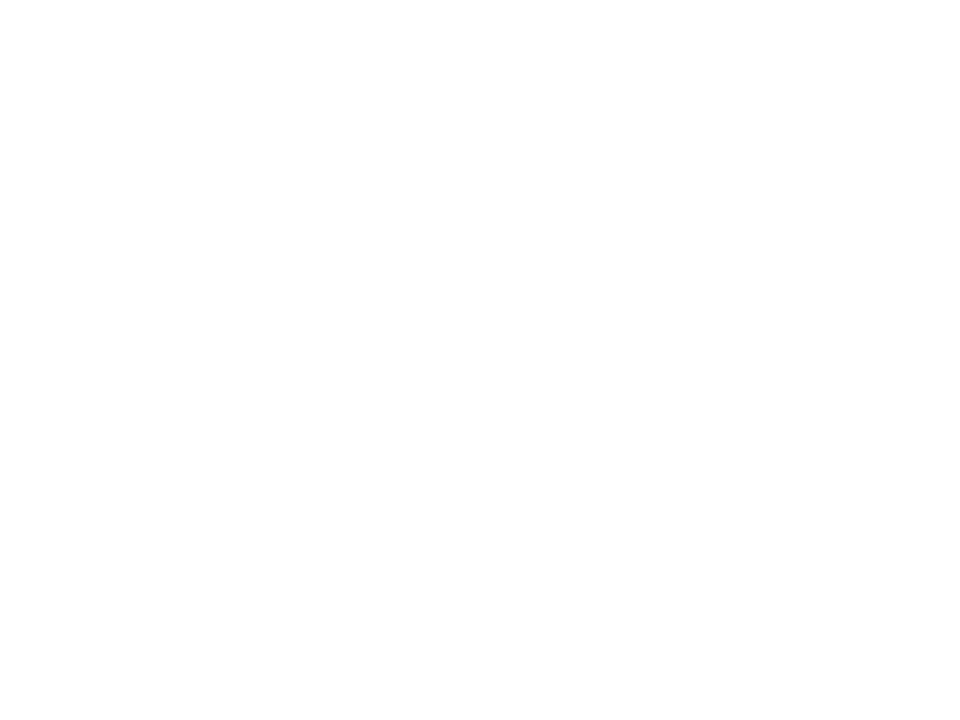

<IPython.core.display.Javascript object>


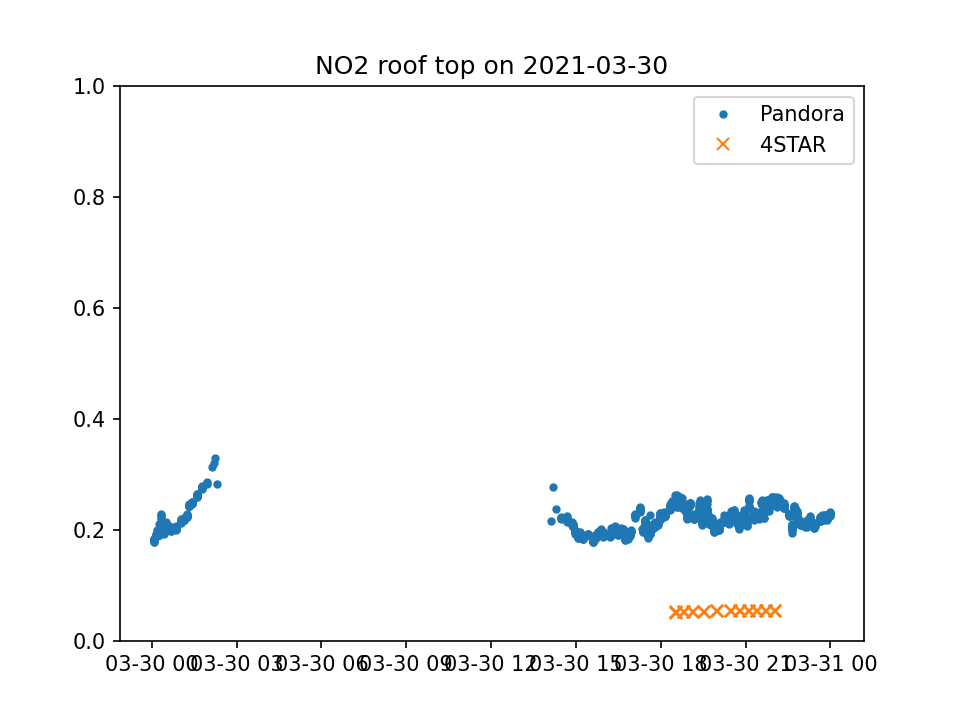

<IPython.core.display.Javascript object>


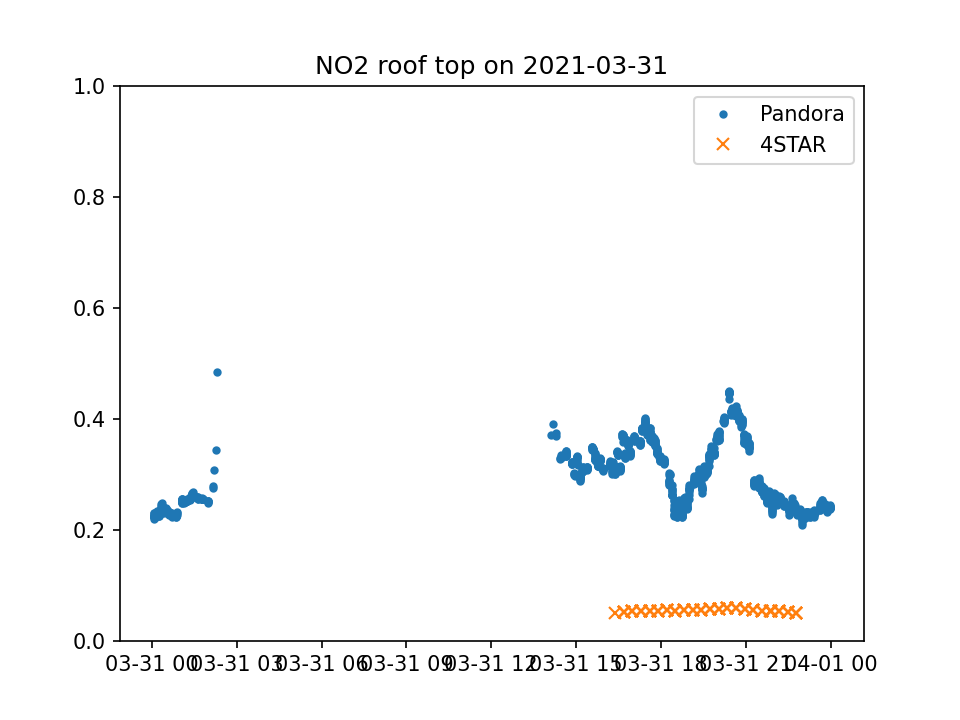

<IPython.core.display.Javascript object>


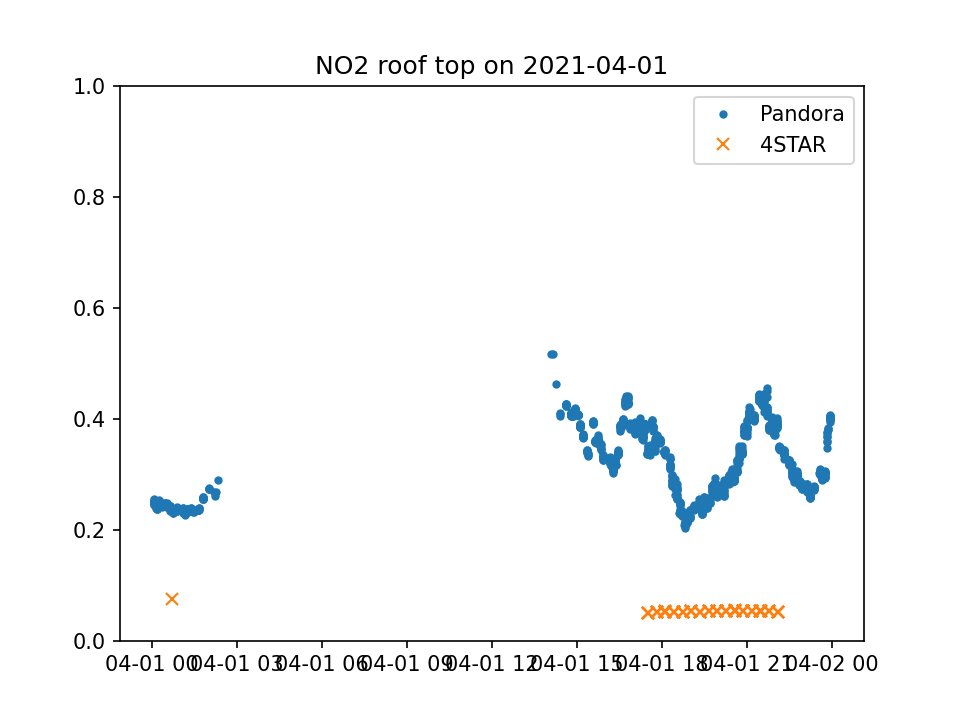

<IPython.core.display.Javascript object>


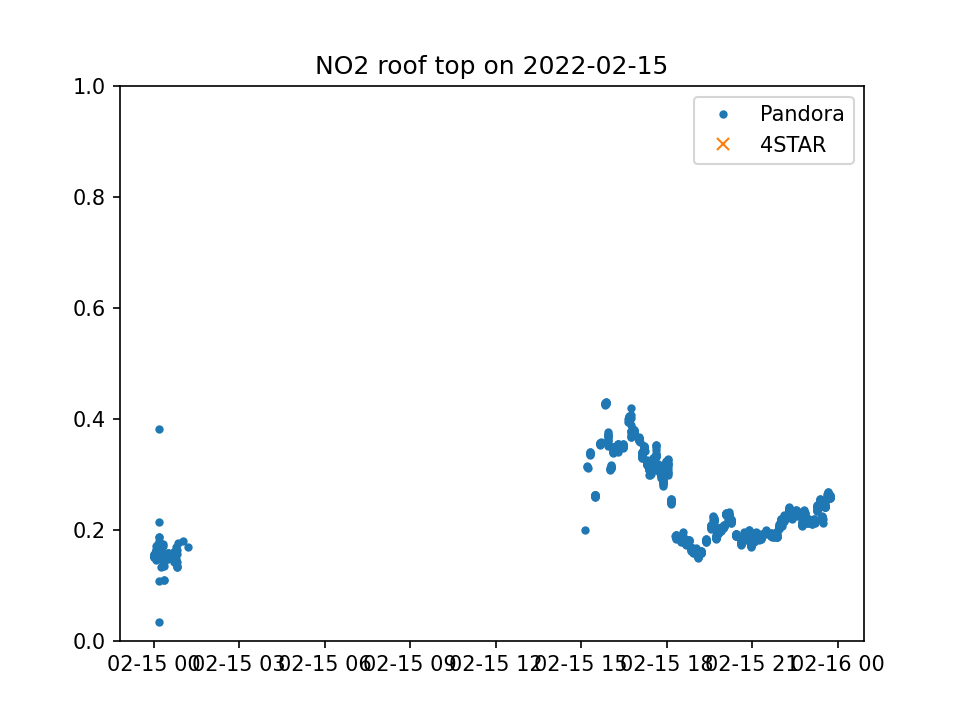

<ipython-input-152-5b40625b7aa6>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


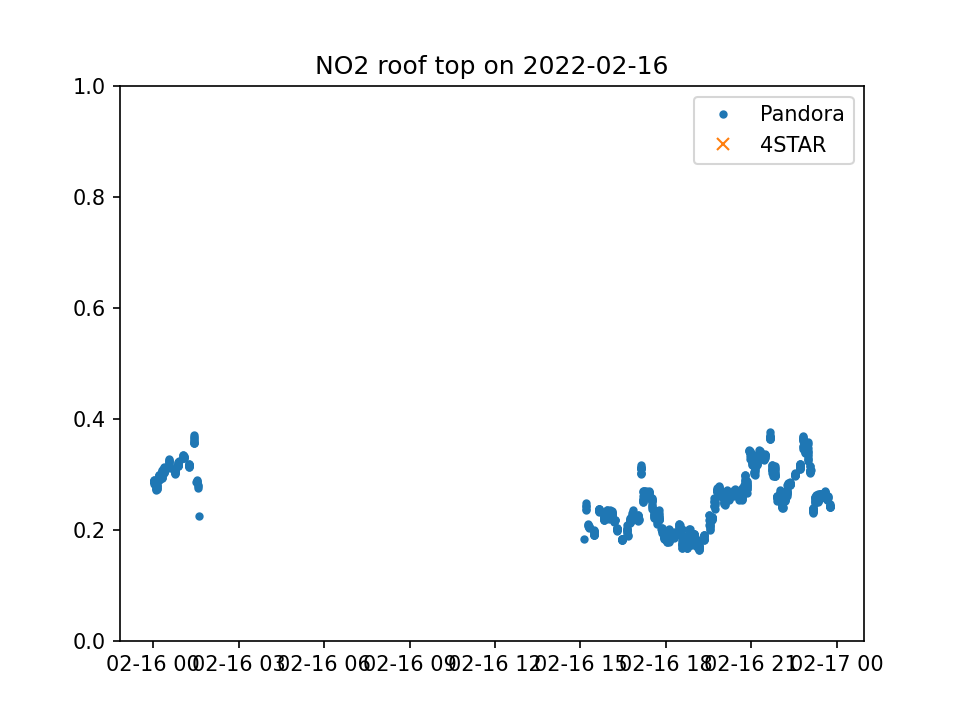

<IPython.core.display.Javascript object>


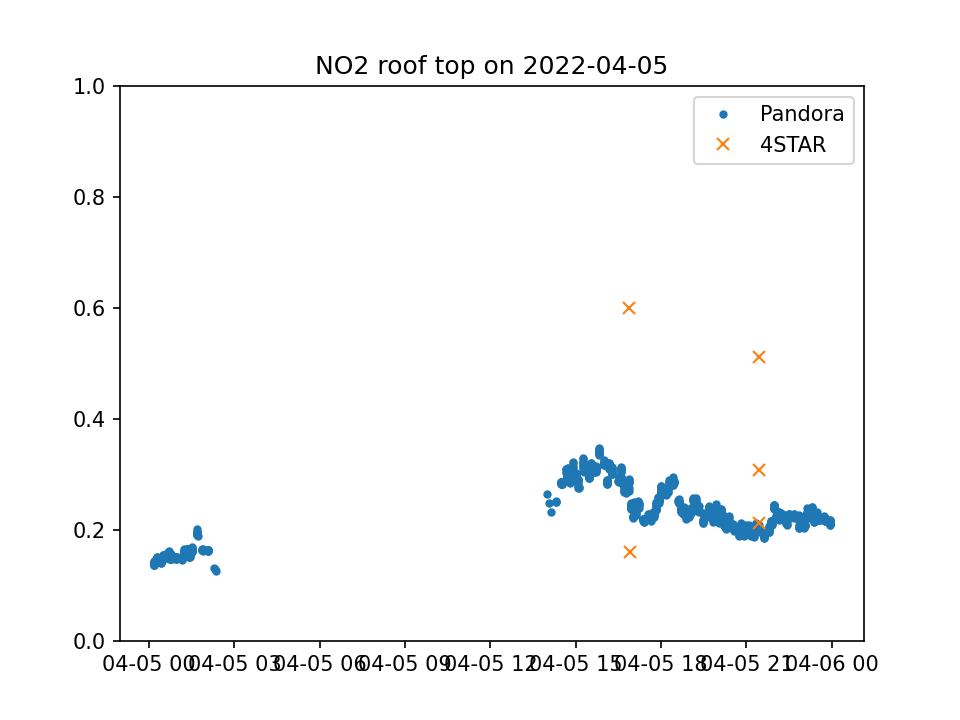

<IPython.core.display.Javascript object>


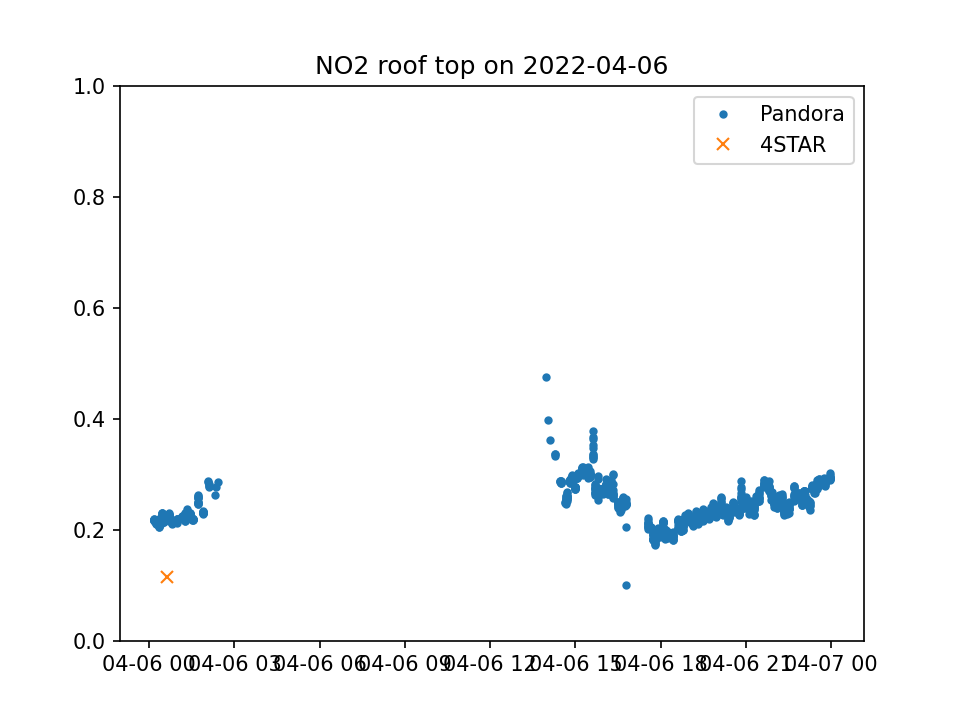

<IPython.core.display.Javascript object>


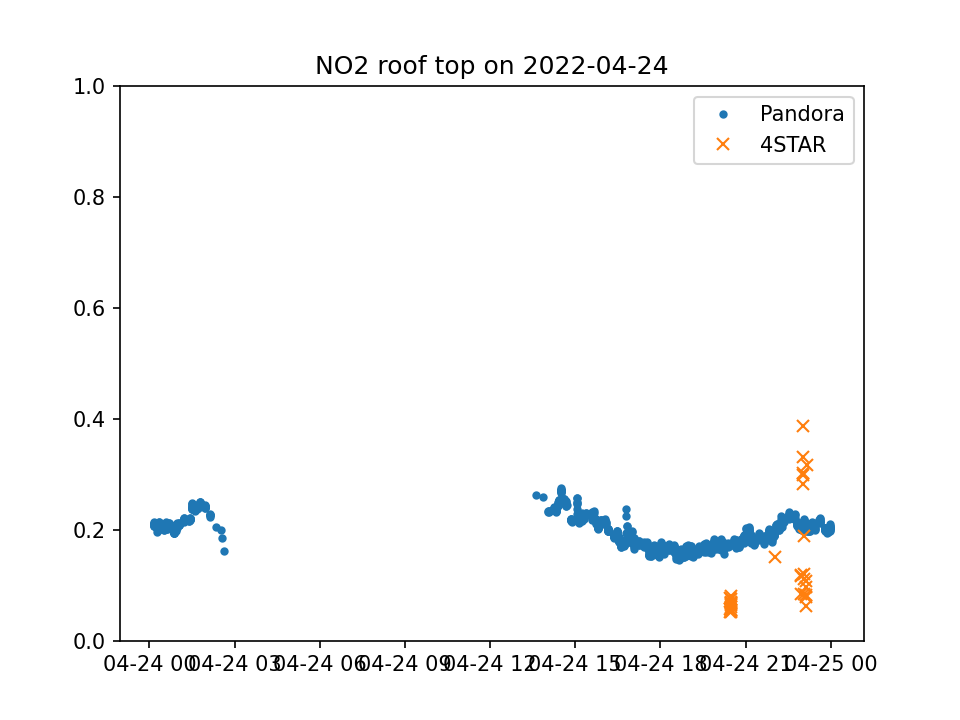

In [152]:
for day in meas_days:
    plt.figure()
    ip = pandora_days_since_2018.astype(int) == day
    iss = days_since_2018.astype(int) == day
    if not any(ip): continue
    plt.plot(pdno2['datetime'][ip],pdno2['no2_du'][ip],'.',label='Pandora')
    plt.plot(s['time'][iss],s['no2DU'][iss],'x',label='4STAR')
    plt.ylim(0,1)
    plt.legend()
    plt.title('NO2 roof top on {}'.format(pdno2['datetime'][ip].iloc[0].date()))

In [68]:
np.max(gas['20200624']['no2DU'])

0.8683142226294103

In [69]:
np.min(gas['20200624']['no2DU'])

0.018609754563390965

In [90]:
g = '20200624'
ii = (pdno2['datetime'].dt.tz_localize(None).to_numpy()>gas[g]['time'][0]-8600000000000) &\
         (pdno2['datetime'].dt.tz_localize(None).to_numpy()<gas[g]['time'][-1]+8600000000000)

<IPython.core.display.Javascript object>


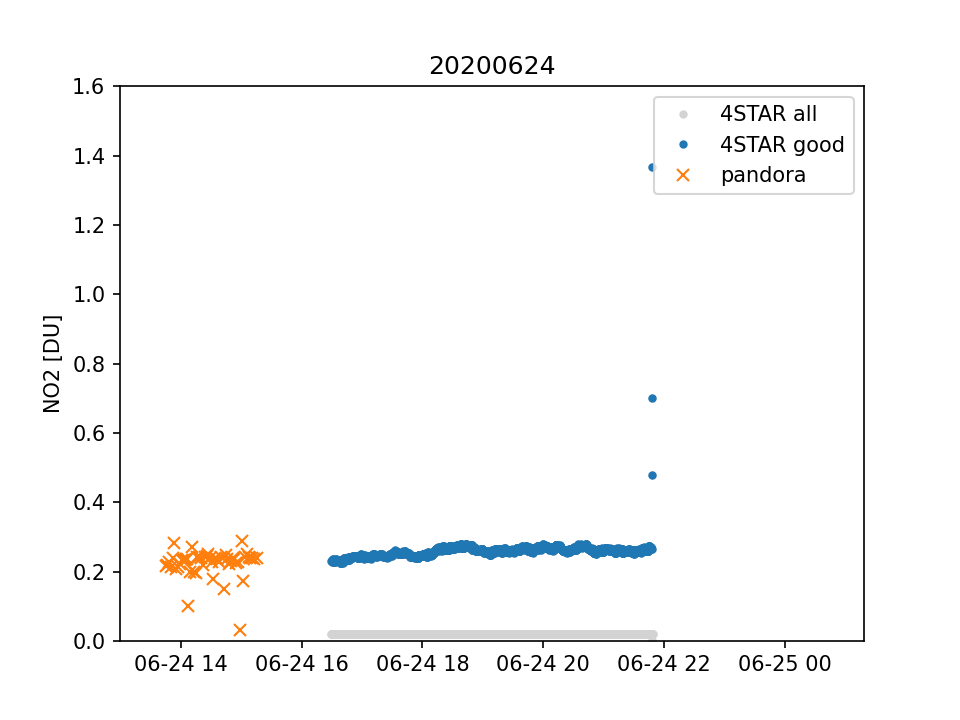

<IPython.core.display.Javascript object>


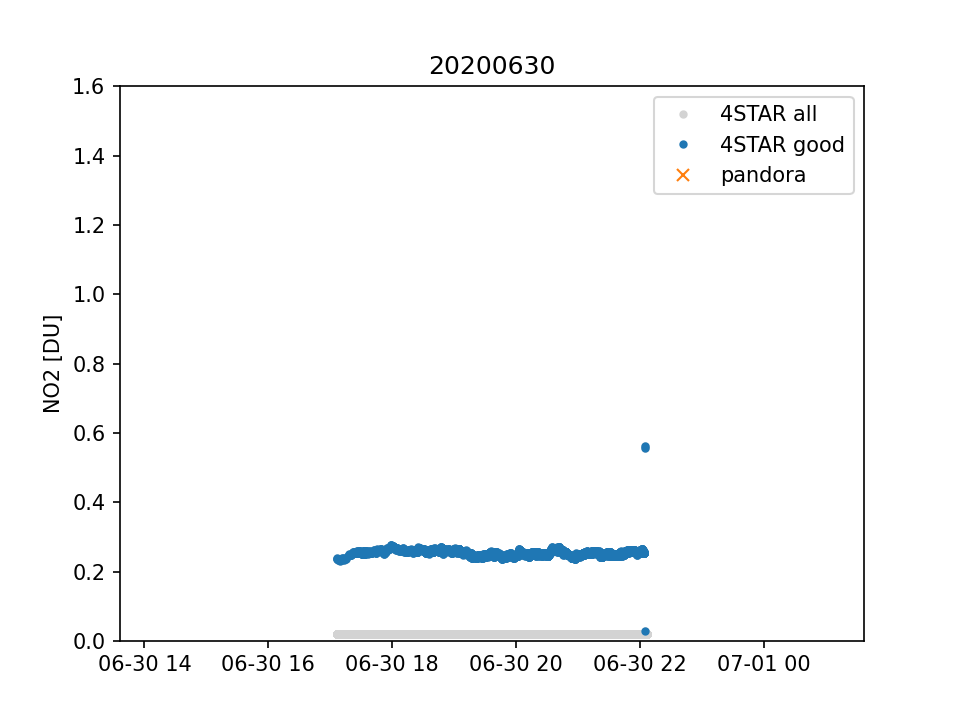

<IPython.core.display.Javascript object>


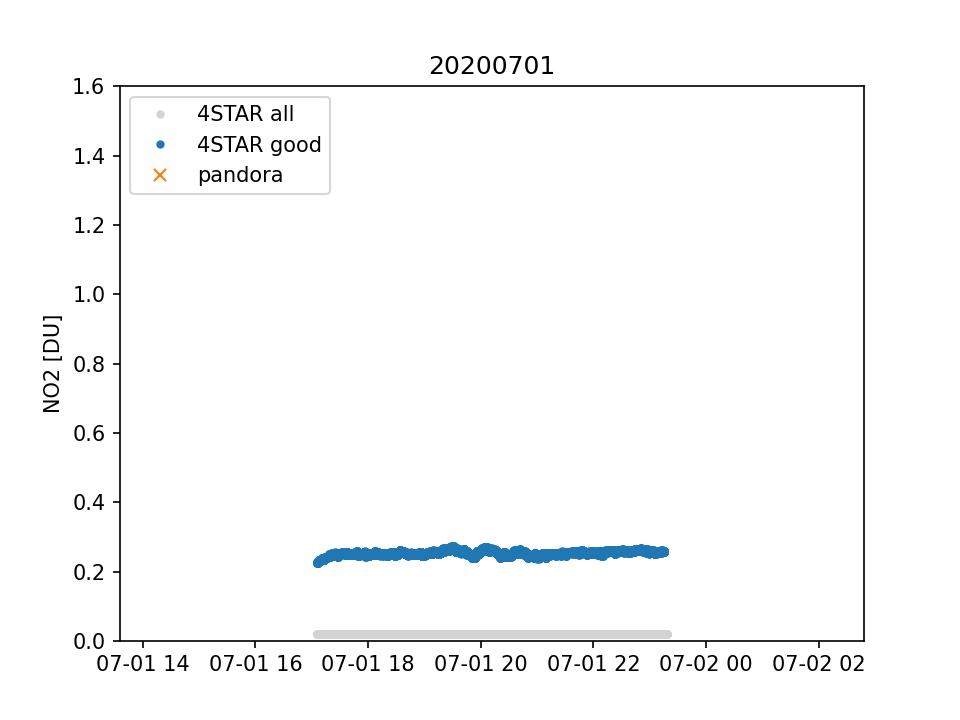

<IPython.core.display.Javascript object>


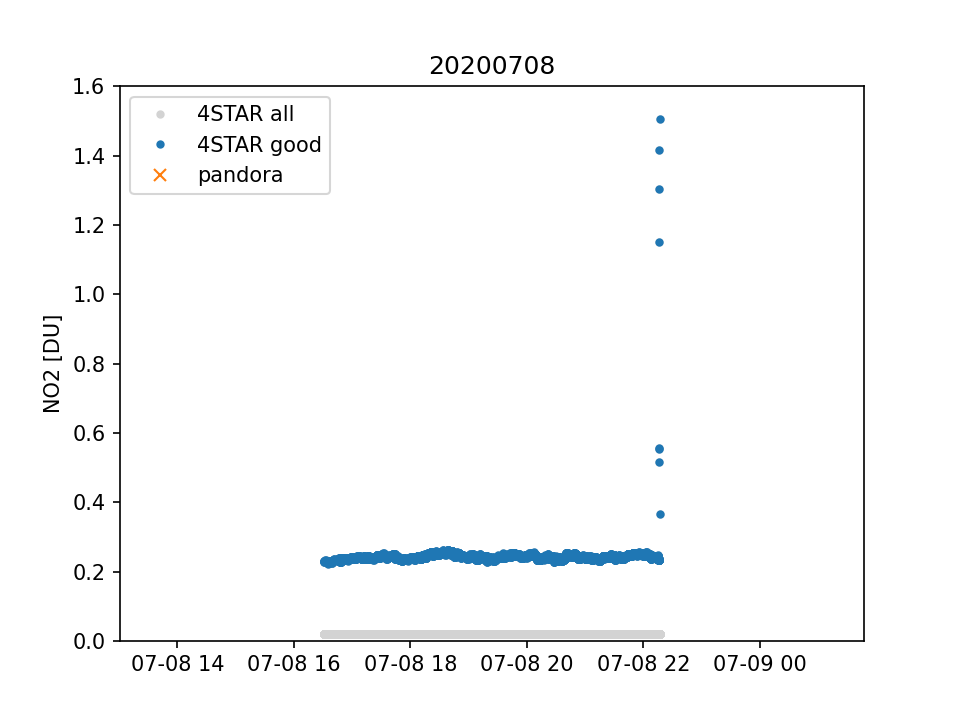

<IPython.core.display.Javascript object>


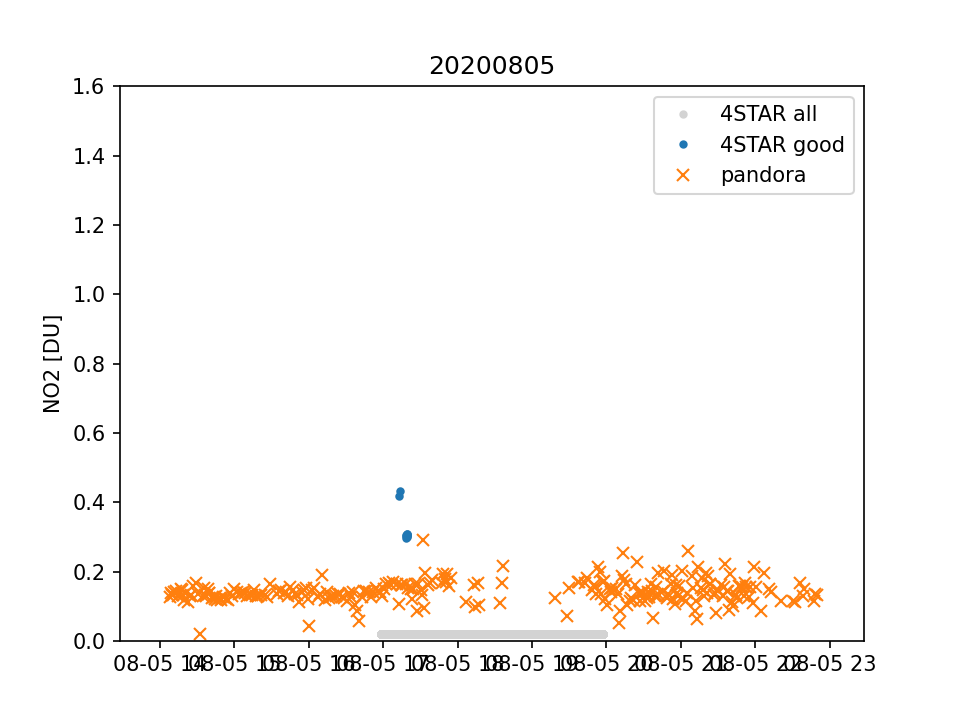

<IPython.core.display.Javascript object>


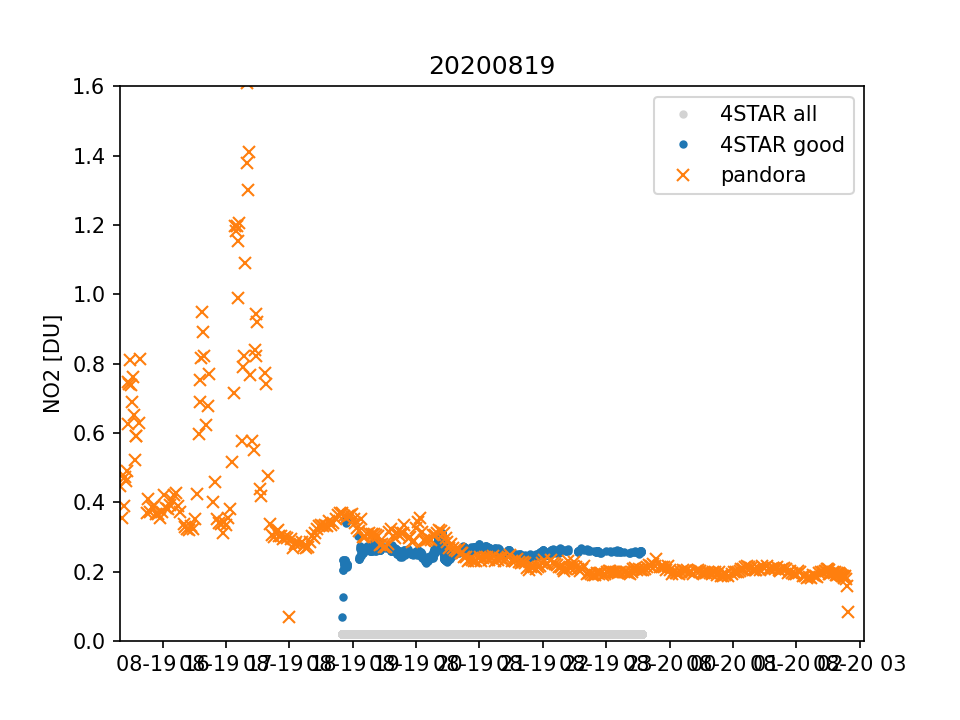

<IPython.core.display.Javascript object>


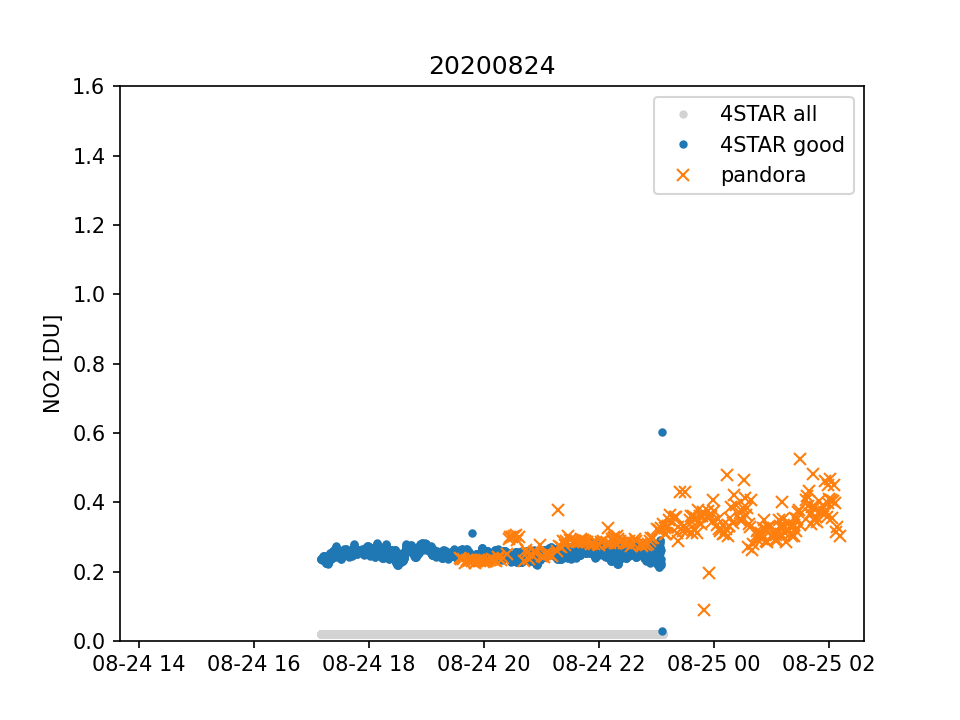

<IPython.core.display.Javascript object>


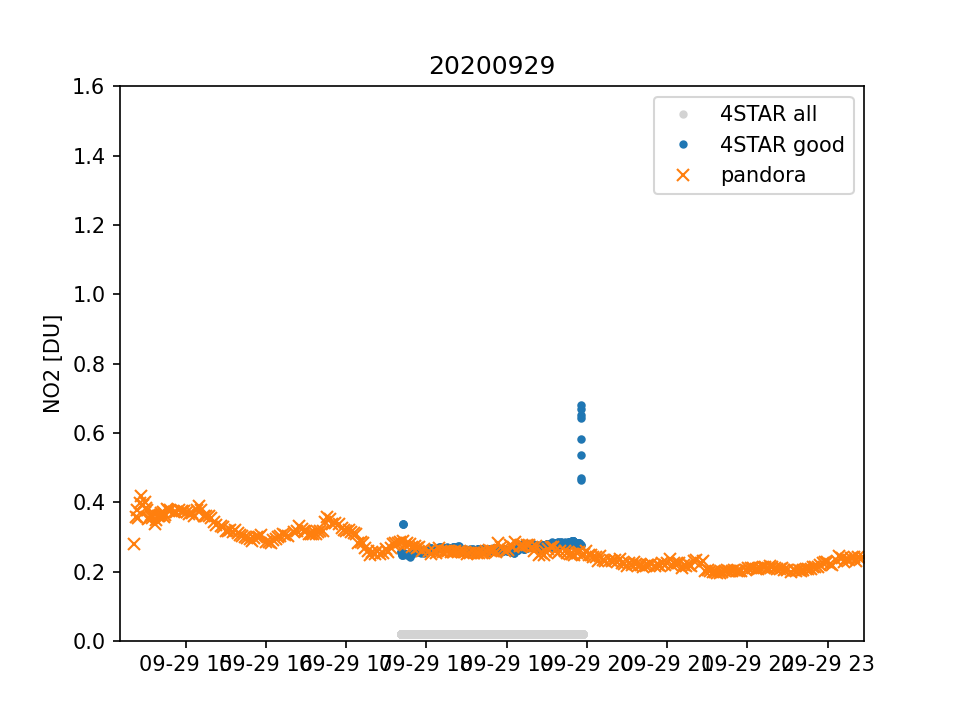

<IPython.core.display.Javascript object>


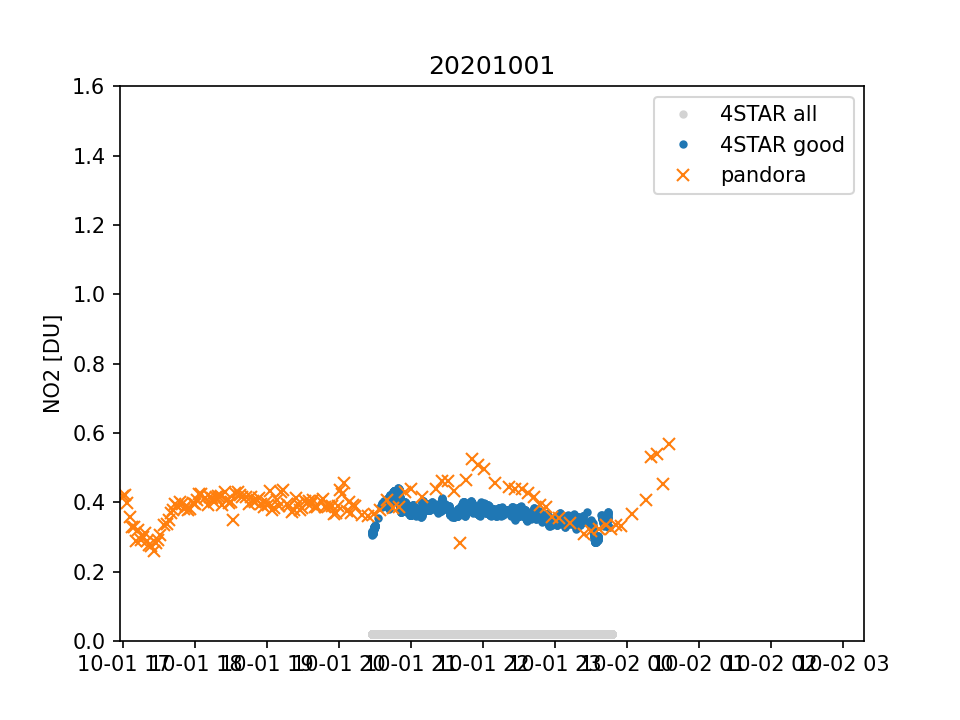

<IPython.core.display.Javascript object>


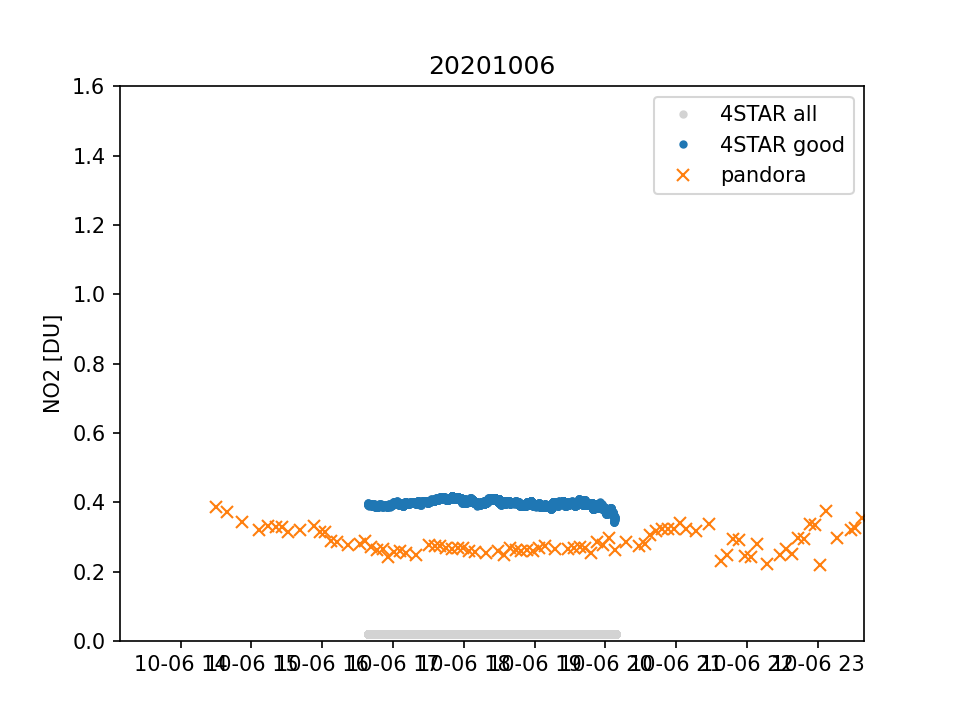

<IPython.core.display.Javascript object>


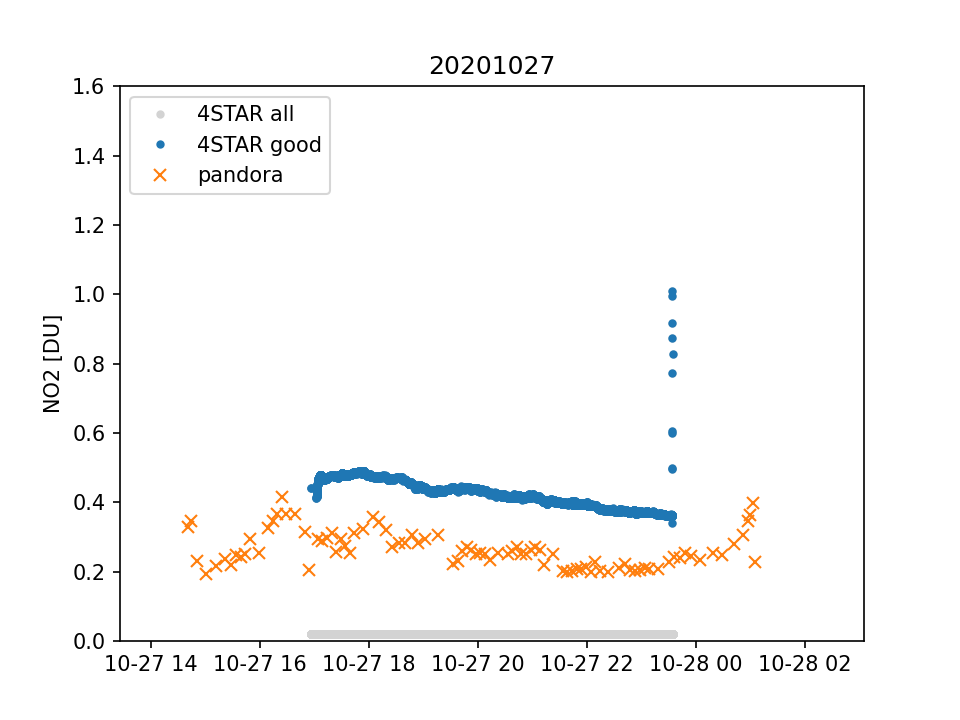

<IPython.core.display.Javascript object>


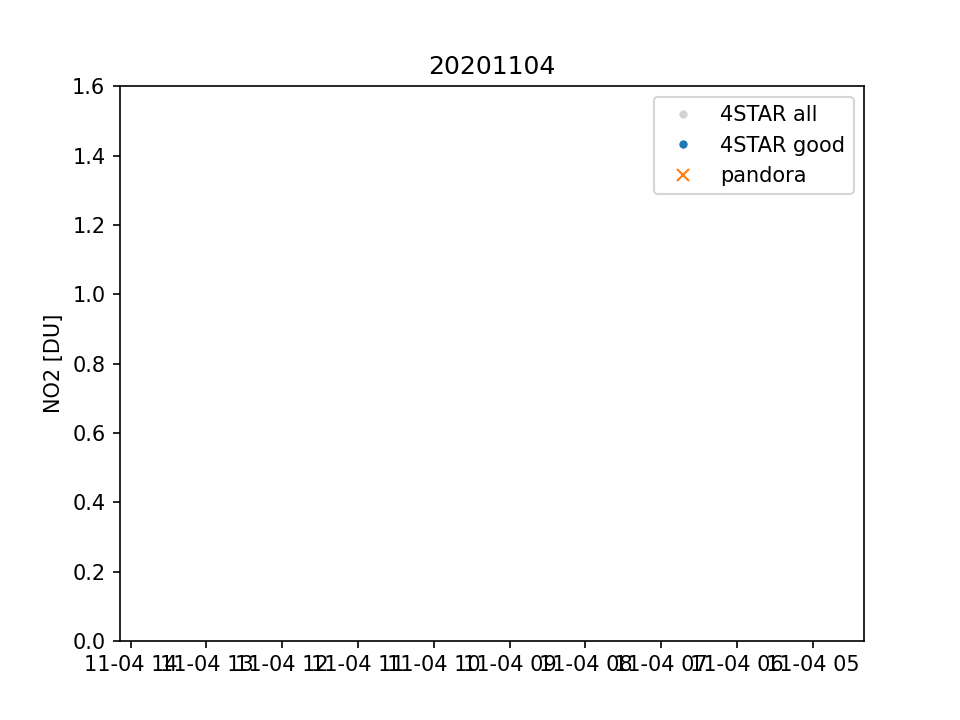

<IPython.core.display.Javascript object>


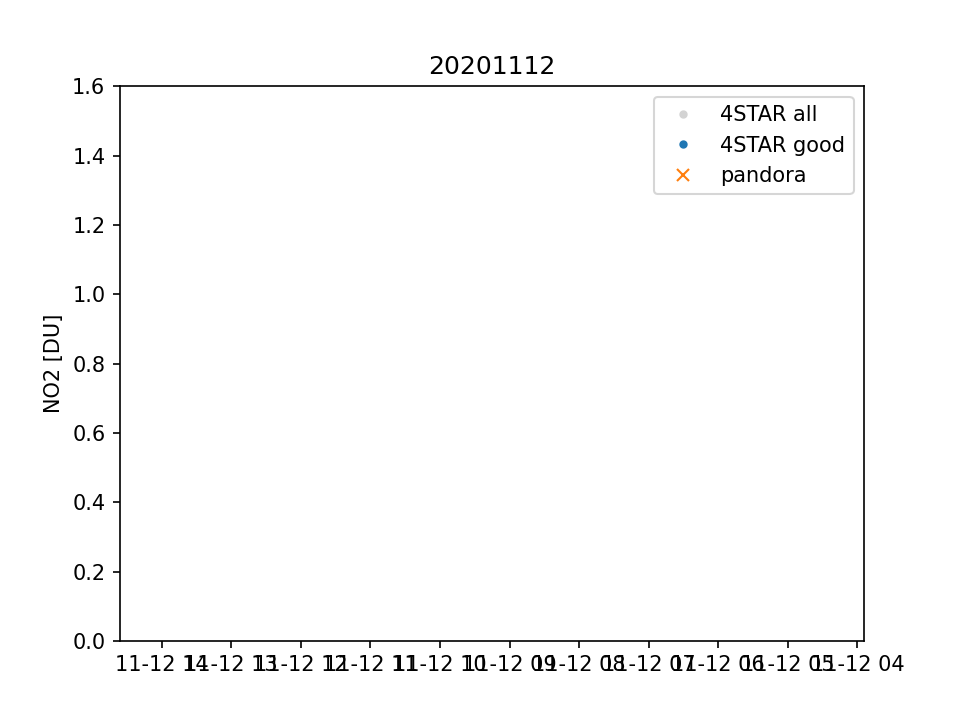

<IPython.core.display.Javascript object>


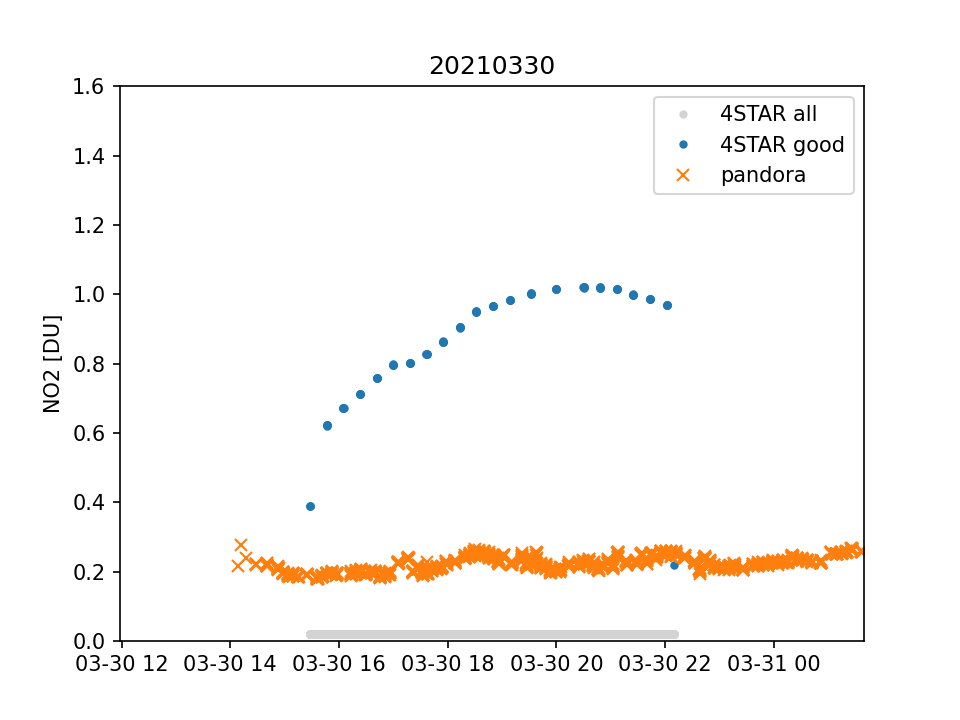

<IPython.core.display.Javascript object>


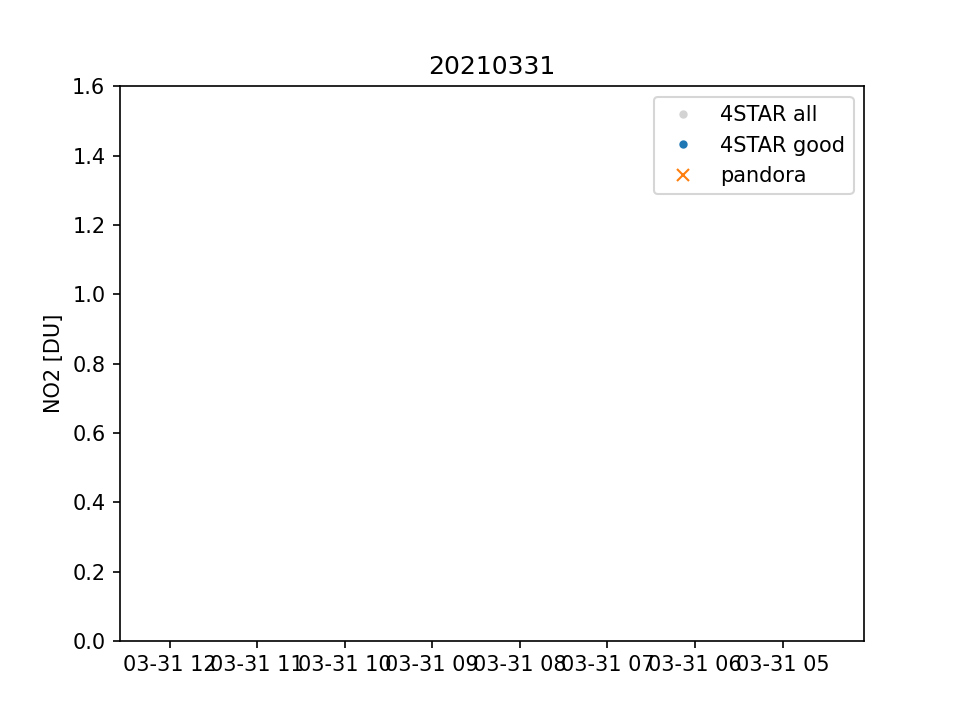

<IPython.core.display.Javascript object>


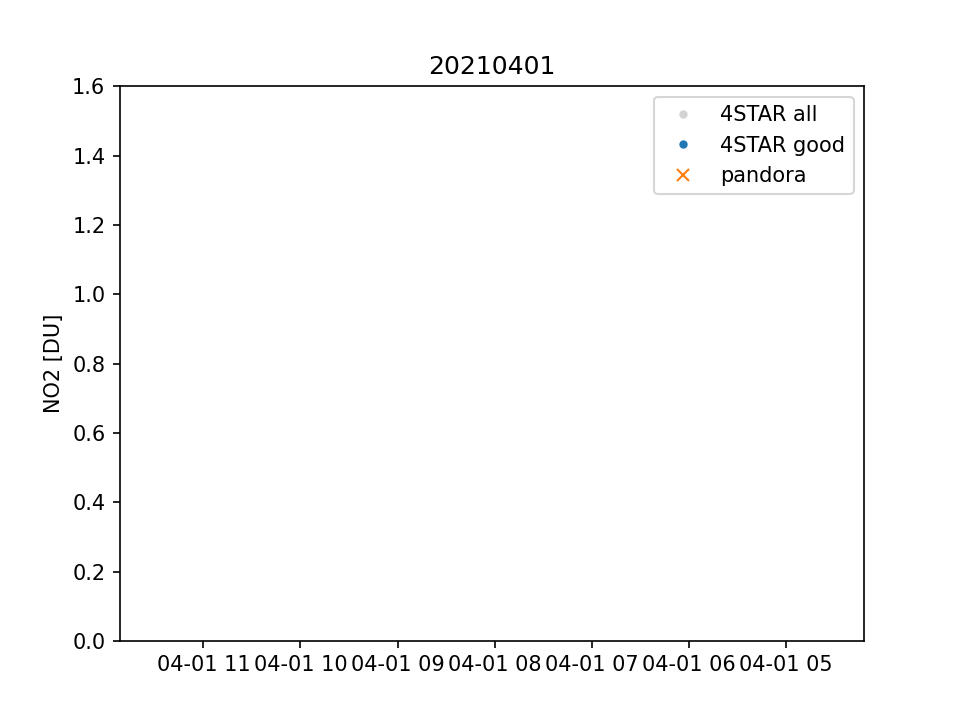

<IPython.core.display.Javascript object>


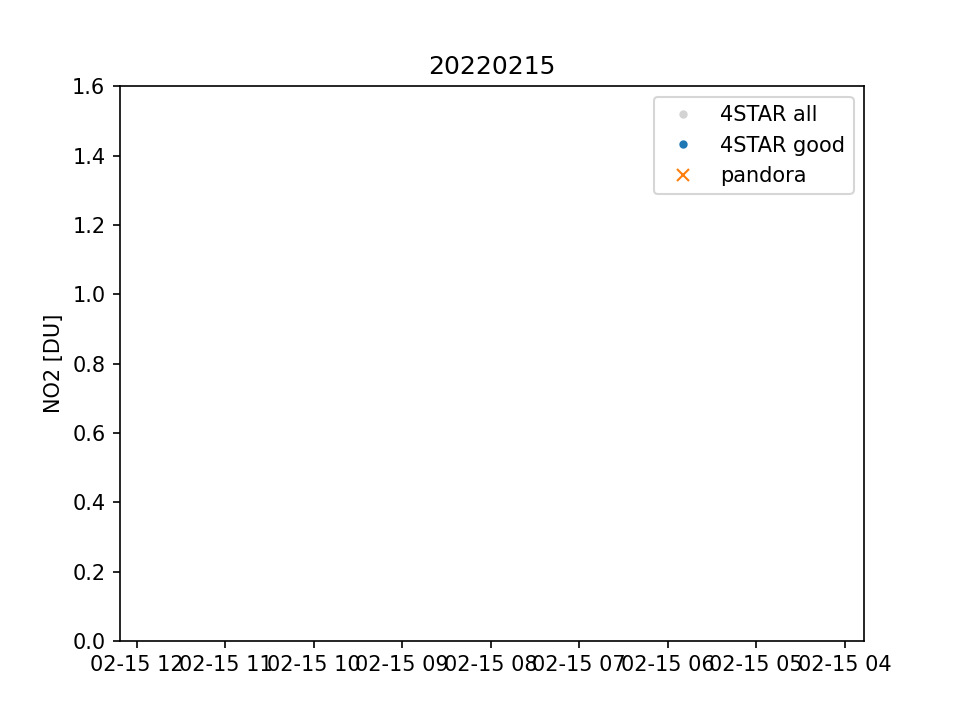

<IPython.core.display.Javascript object>


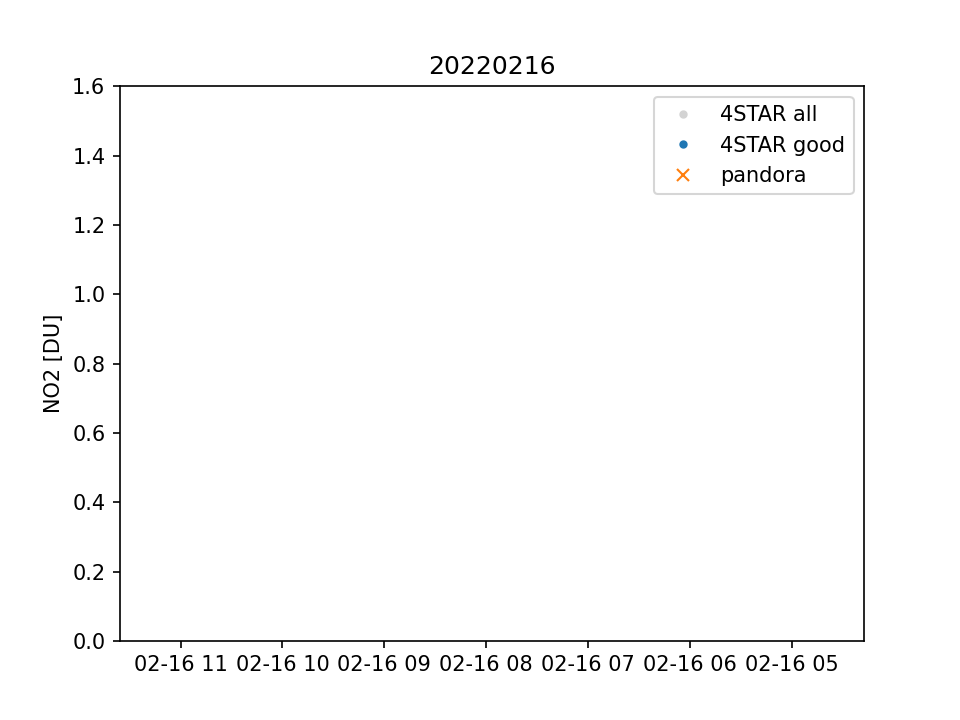

<IPython.core.display.Javascript object>


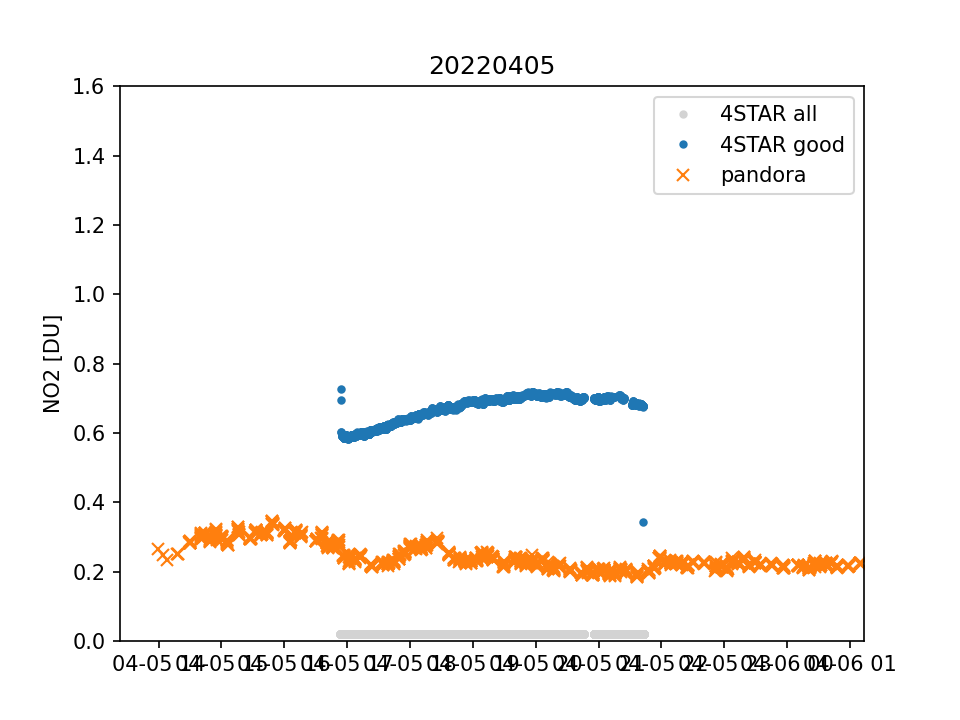

<IPython.core.display.Javascript object>


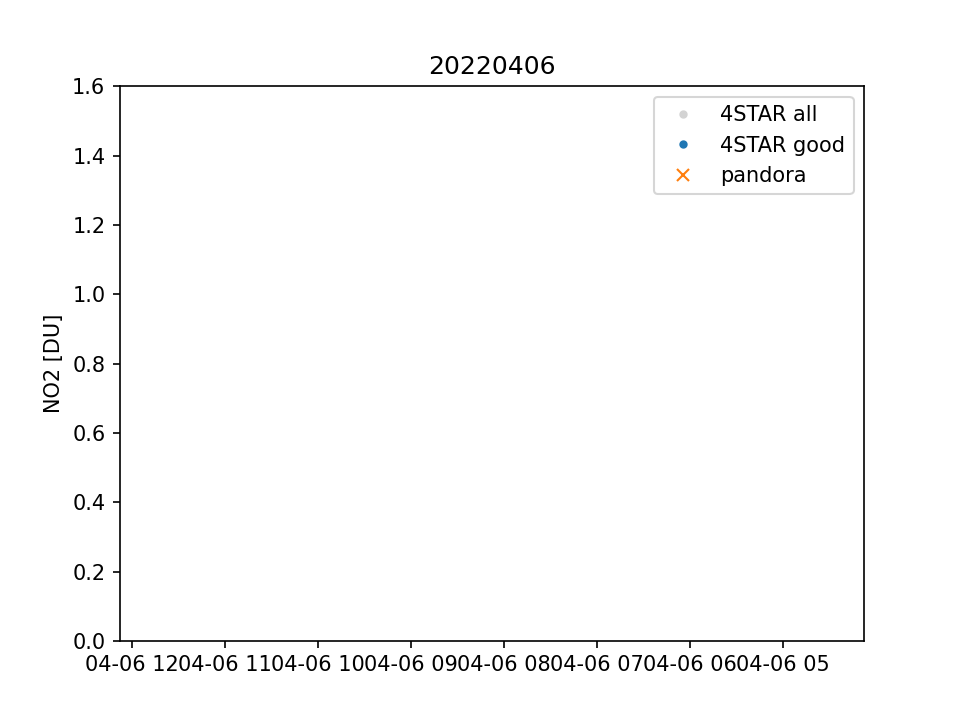

<IPython.core.display.Javascript object>


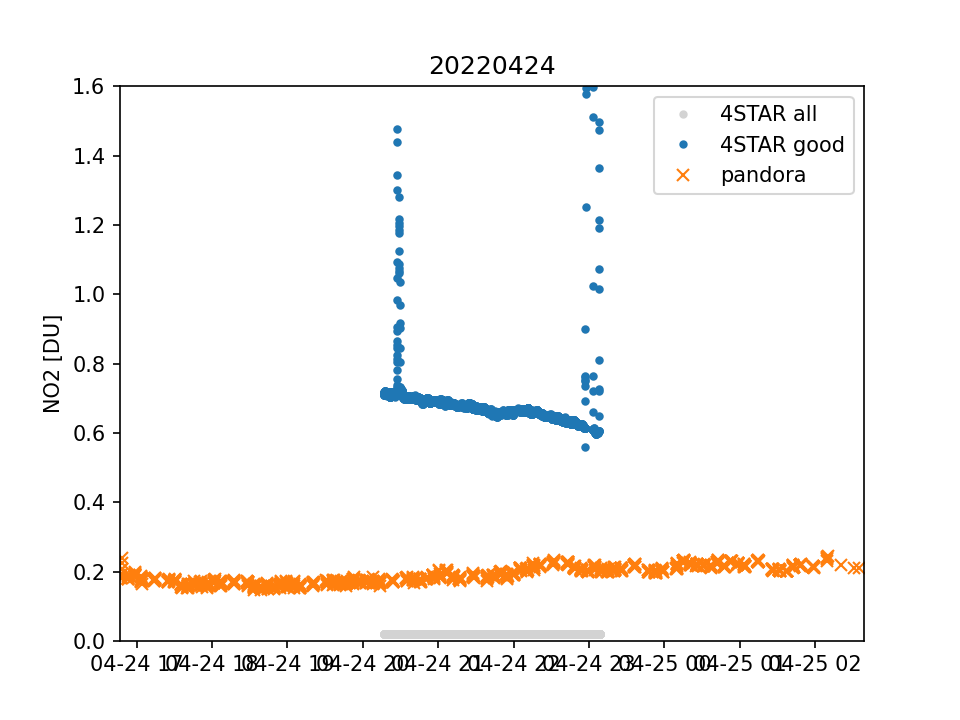

In [74]:
for g in gas:
    plt.figure()
    igood = (gas[g]['no2DU'][:,0] > 0.025) & (gas[g]['no2resiDU'][:,0]<0.05)
    plt.plot(gas[g]['time'],gas[g]['no2DU'],'.',color='lightgrey',label='4STAR all')
    plt.plot(gas[g]['time'][igood],gas[g]['no2DU'][igood],'.',label='4STAR good')
    ii = (pdno2['datetime'].dt.tz_localize(None).to_numpy()>gas[g]['time'][0]-12600000000000) &\
         (pdno2['datetime'].dt.tz_localize(None).to_numpy()<gas[g]['time'][-1]+12600000000000)
    plt.plot(pdno2['datetime'][ii],pdno2['no2_du'][ii],'x',label='pandora')
    plt.xlim([gas[g]['time'][0]-12600000000000,gas[g]['time'][-1]+12600000000000])
    plt.ylim(0.0,1.6)
    plt.legend()
    
    plt.ylabel('NO2 [DU]')
    plt.title(g)

In [89]:
no2_star = []
no2_pand = []
titles = []
for g in gas:
    igood = (gas[g]['no2DU'][:,0] > 0.025) & (gas[g]['no2resiDU'][:,0]<0.05)
    ii = (pdno2['datetime'].dt.tz_localize(None).to_numpy()>gas[g]['time'][0]-12600000000000) &\
         (pdno2['datetime'].dt.tz_localize(None).to_numpy()<gas[g]['time'][-1]+12600000000000)
    no2_star.append(gas[g]['no2DU'][igood])
    no2_pand.append(pdno2['no2_du'][ii].to_numpy())
    titles.append(g)

In [95]:
no2_star2 = [o.flatten() for o in no2_star]
no2_pand2 = [o.flatten() for o in no2_pand]

<IPython.core.display.Javascript object>


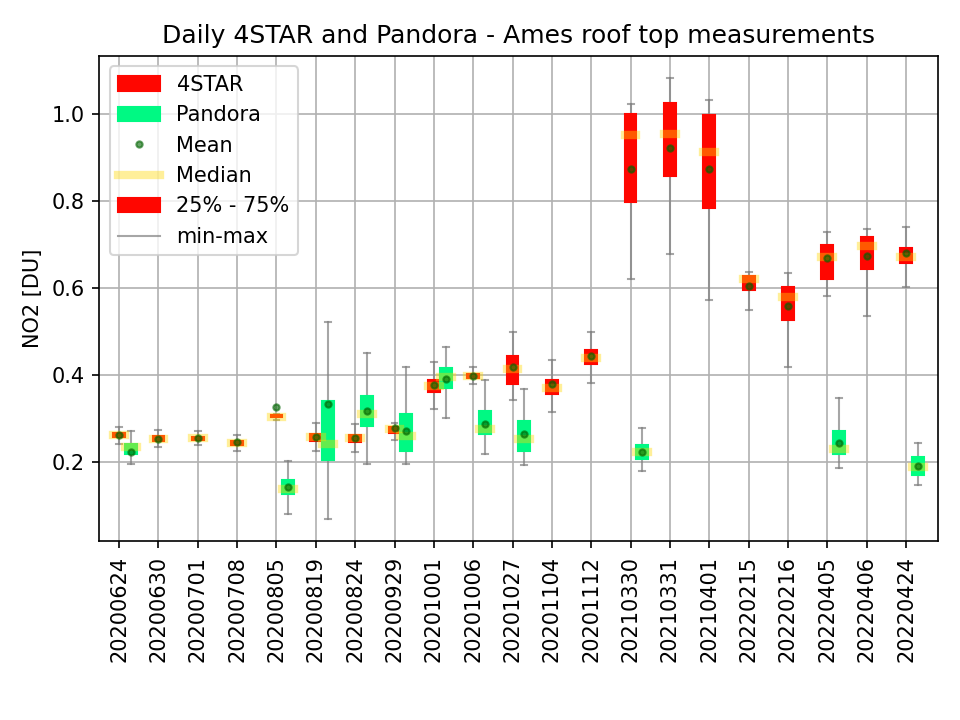

In [126]:
plt.figure()
gr = plt.cm.autumn_r
dummy_n = np.arange(0,len(no2_star2))*0.0+200.0
dummy_n[-1] = 205.0
bp = plt.boxplot(no2_star2,vert=True,positions=np.arange(0,len(no2_star2)),
                   showfliers=False,widths=0.3,showmeans=True,patch_artist=True)
pu.set_box_whisker_color(gr,bp,dummy_n,whisker_color='grey')
grp = plt.cm.winter
bpp = plt.boxplot(no2_pand2,vert=True,positions=np.arange(0,len(no2_star2))+0.3,
                   showfliers=False,widths=0.3,showmeans=True,patch_artist=True)
pu.set_box_whisker_color(grp,bpp,dummy_n,whisker_color='grey')
plt.gca().set_xticks(np.arange(0,len(no2_star2)))
plt.gca().set_xticklabels(titles,rotation=90)
plt.grid()
plt.ylabel('NO2 [DU]')
plt.title('Daily 4STAR and Pandora - Ames roof top measurements')
plt.legend([bp['boxes'][0],bpp['boxes'][0],bp['means'][0],bp['medians'][0],bp['boxes'][0],bp['whiskers'][0]],
               ['4STAR','Pandora','Mean','Median','25% - 75%','min-max'],
               frameon=True,loc=0,numpoints=1)
plt.tight_layout(rect=(0,0.05,1,1))
plt.savefig(fp + '/gas_summary_v3/daily_4STAR_pandora_NO2_{}.png',dpi=600,transparent=True)

## Match in time to compare each measurement

### Time delta fast version - but buggy?

In [95]:
time_diff = pdno2['datetime'].dt.tz_localize(None).to_numpy()-np.append(s['time'],s['time'][np.zeros((len(pdno2['datetime'])-len(s['time']),1)).astype(int)])

In [126]:
time_diff = time_diff.astype(float)/1E9 #convert to seconds

In [130]:
imatch = time_diff<600

<IPython.core.display.Javascript object>


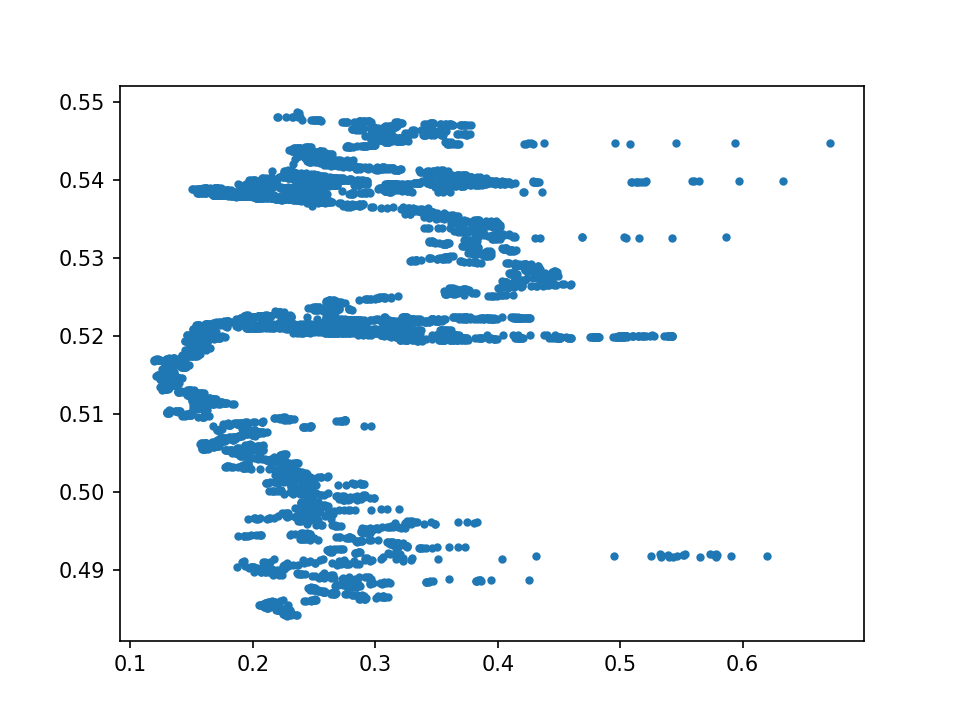

In [165]:
plt.figure()
plt.plot(pdno2['no2_du'][imatch],s_no2DU[imatch[0:len(s['no2DU'])]],'.')


In [117]:
imatch.sum()

5990

### Match in time, slow loop version

In [48]:
def get_unixtime(dt64):
    return dt64.astype('datetime64[ms]').astype('float')/1000.0

In [49]:
t = s['time'][10000]

In [52]:
get_unixtime(t)

1593027178.577

In [53]:
t0 = pdno2['datetime'].dt.tz_localize(None).to_numpy()

In [54]:
get_unixtime(t0[10000])

1577039984.0

In [55]:
from tqdm import tqdm_notebook as tqdm 

In [71]:
time_span = 300 #in seconds
match_pandora_no2 = []
match_4star_no2 = []

unix_t0 = get_unixtime(t0)
unix_t = get_unixtime(s['time'])

pbar = tqdm(total = len(unix_t))
nstep = 50

for t in unix_t[::nstep]:
    imatch = (unix_t0<=t+time_span) & (unix_t0>=t-time_span)
    if any(imatch):
        match_pandora_no2.append(np.nanmean(pdno2['no2_du'][imatch]))
        match_4star_no2.append(np.nanmean(s['no2DU'][(unix_t<=t+time_span) & (unix_t>=t-time_span)]))
    else:
        match_pandora_no2.append(np.nan)
        match_4star_no2.append(np.nan)
    pbar.update(nstep)
match_pandora_no2 = np.array(match_pandora_no2)
match_4star_no2 = np.array(match_4star_no2)

<ipython-input-71-9782992aac08>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(total = len(unix_t))


  0%|          | 0/392329 [00:00<?, ?it/s]

<ipython-input-71-9782992aac08>:14: RuntimeWarning: Mean of empty slice
  match_4star_no2.append(np.nanmean(s['no2DU'][(unix_t<=t+time_span) & (unix_t>=t-time_span)]))


In [117]:
days_since_2020 = (unix_t-get_unixtime(np.datetime64('2020-01-01T00:00:00.0')))/60.0/60.0/24.0

<IPython.core.display.Javascript object>


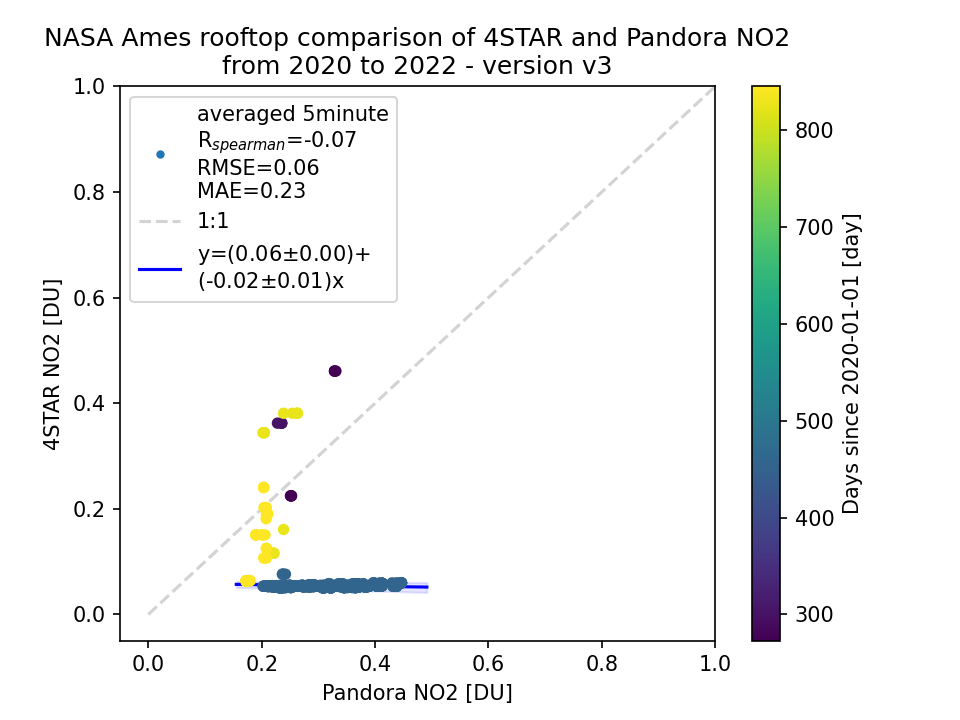

In [79]:
plt.figure()
plt.plot(match_pandora_no2,match_4star_no2,'.',label='averaged 5minute\n'+pu.stats_label(match_pandora_no2,match_4star_no2))
plt.plot([0,1],[0,1],'--',color='lightgrey',label='1:1')
pu.plot_lin(match_pandora_no2,match_4star_no2,x_err=match_pandora_no2*0.2,y_err=match_4star_no2*0.2,use_method='york')
plt.legend()
plt.scatter(match_pandora_no2,match_4star_no2,s=20,c=days_since_2020[::nstep],marker='o',zorder=10)
plt.colorbar(label='Days since 2020-01-01 [day]')
plt.ylabel('4STAR NO2 [DU]')
plt.xlabel('Pandora NO2 [DU]')
plt.title('NASA Ames rooftop comparison of 4STAR and Pandora NO2\nfrom 2020 to 2022 - version {}'.format(vv))
plt.ylim(-0.05,1)
plt.xlim(-0.05,1)
plt.savefig(fp+'4STAR_pandora_NO2_comparison_{}.png'.format(vv),dpi=600,transparent=True)

## one to one plot, matching measurement times

### Ozone

In [80]:
spd = pd.DataFrame(s)
spd['datetime'] = pd.to_datetime(s['time'],utc=True)
spd2 = spd.sort_values(by='datetime')

In [81]:
fullpd = pd.merge_asof(spd2,pdo3,direction='nearest')

In [82]:
fullpd['o3DU'][fullpd['o3DU']<0.0] = np.nan

<ipython-input-82-e085c9f2dfe0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fullpd['o3DU'][fullpd['o3DU']<0.0] = np.nan


In [83]:
fullpd['o3_du'][fullpd['qa_o3']>100] = np.nan

<ipython-input-83-bfda56061df8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fullpd['o3_du'][fullpd['qa_o3']>100] = np.nan


In [84]:
fullpd['o3_du'] = fullpd['o3_du']/10.0

<IPython.core.display.Javascript object>


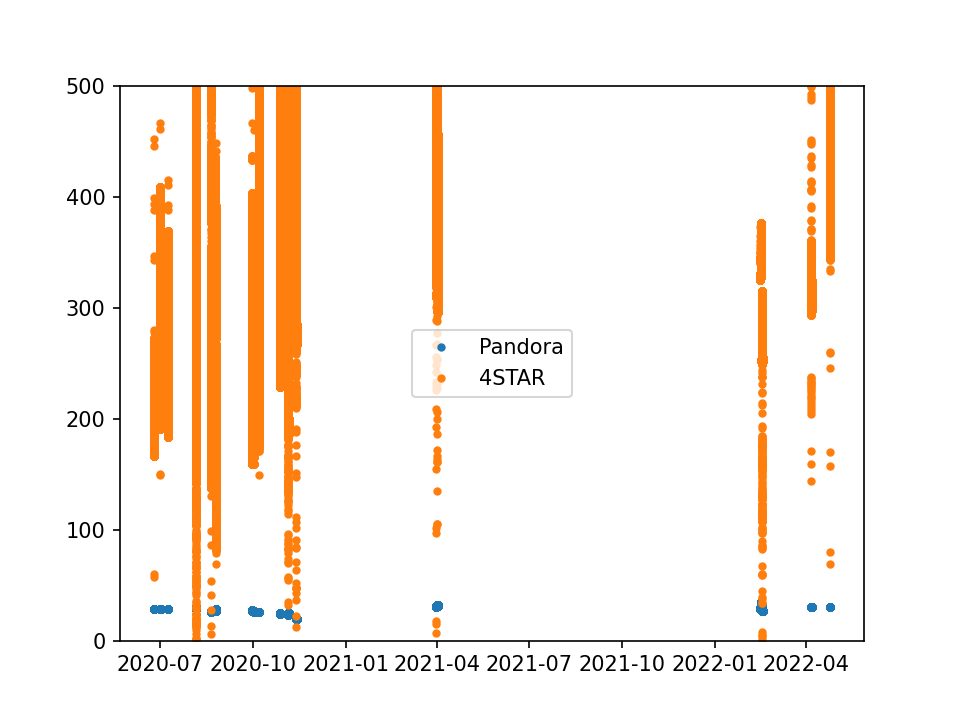

In [85]:
plt.figure()
plt.plot(fullpd['datetime'],fullpd['o3_du'],'.',label='Pandora')
plt.plot(fullpd['datetime'],fullpd['o3DU'],'.',label='4STAR')
plt.ylim(0,500)
plt.legend()

In [88]:
import plotting_utils as pu
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [89]:
fl = np.isfinite(fullpd['o3_du']) & np.isfinite(fullpd['o3DU'])

In [90]:
r = st.spearmanr(fullpd['o3_du'],fullpd['o3DU'],nan_policy='omit')

In [91]:
r.correlation

0.4880627834106976

In [93]:
rmse = mean_squared_error(fullpd['o3_du'][fl],fullpd['o3DU'][fl],squared=True)
rmse

127608.3126697041

In [94]:
mae = mean_absolute_error(fullpd['o3_du'][fl],fullpd['o3DU'][fl])
mae

273.7659336056577

In [95]:
import importlib
importlib.reload(pu)

<module 'plotting_utils' from '/home/sam/python_codes/plotting_utils.py'>

In [96]:
from Sp_parameters import doublenanmask, nanmasked
from scipy import odr
from linfit import linfit

In [97]:
x = fullpd['o3_du']
y = fullpd['o3DU']
x_err = fullpd['unc_o3_du']
y_err = fullpd['o3resiDU']

In [98]:
xn,yn,mask = doublenanmask(x,y,return_mask=True)

In [99]:
model = odr.Model(lin)
dat = odr.RealData(xn,yn,sx=x_err[mask],sy=y_err[mask])

NameError: name 'lin' is not defined

In [100]:
c,cm = linfit(xn,yn)
p = np.array([c[1],c[0]])

In [101]:
imask = mask & (y_err>0)

In [102]:
ri = np.corrcoef(x_err[imask],y_err[imask])[0,1]

In [103]:
a_bivar, b_bivar, S, cov = pu.bivariate_fit(xn,yn,x_err[imask],y_err[imask],b0=p[1],ri=ri**2)

In [104]:
a_bivar

-3527.471996468812

In [105]:
b_bivar

130.3379338083534

In [106]:
S

125750959.53474799

In [107]:
np.sqrt(cov[1,1])*b_bivar

117.59009944525893

<IPython.core.display.Javascript object>


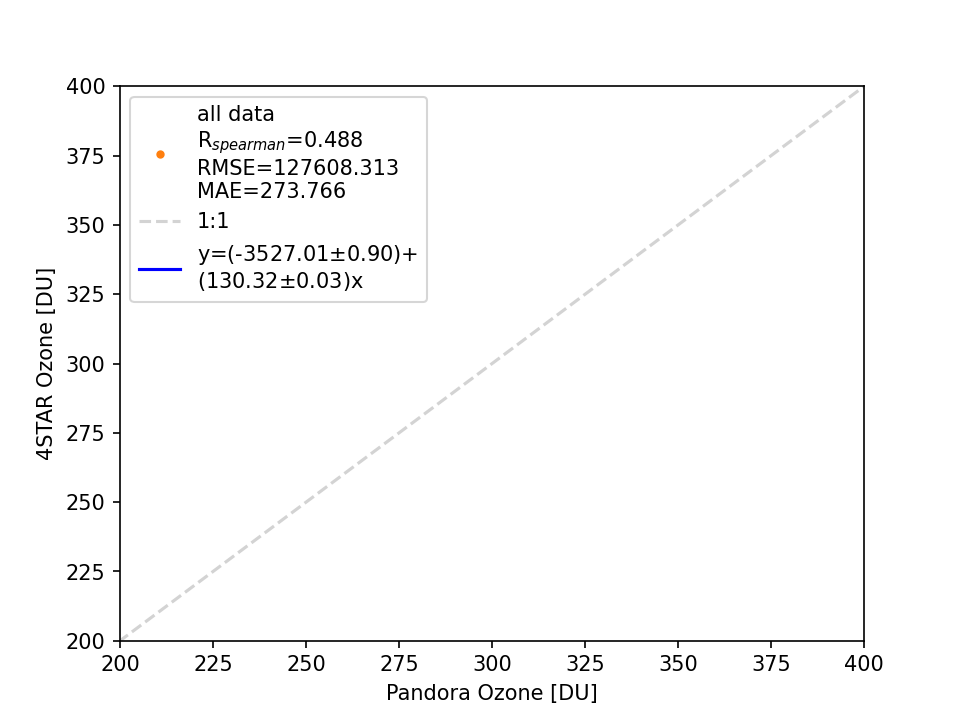

In [108]:
plt.figure()
plt.errorbar(fullpd['o3_du'],fullpd['o3DU'],xerr=fullpd['unc_o3_du'],yerr=fullpd['o3resiDU'],marker='.',ls='')
plt.plot(fullpd['o3_du'],fullpd['o3DU'],'.',
         label='all data\nR$_{{spearman}}$={:1.3f}\nRMSE={:1.3f}\nMAE={:1.3f}'.format(r.correlation,rmse,mae))
plt.plot([0,500],[0,500],'--',color='lightgrey',label='1:1')
pu.plot_lin(fullpd['o3_du'],fullpd['o3DU'],x_err=fullpd['unc_o3_du'],y_err=fullpd['o3resiDU'],use_method='york')
plt.legend()
plt.ylabel('4STAR Ozone [DU]')
plt.xlabel('Pandora Ozone [DU]')
plt.ylim(200,400)
plt.xlim(200,400)
plt.savefig(fp+'Winter_2022/plots/4STAR_to_Pandora_O3_{}.png'.format(vv),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


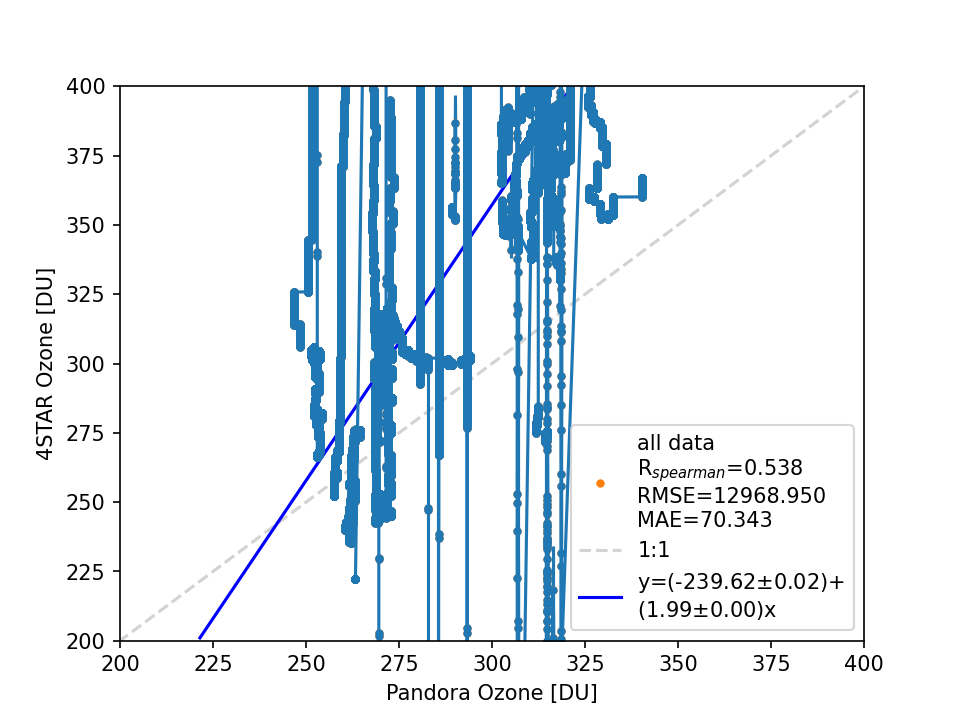

In [401]:
plt.figure()
plt.errorbar(fullpd['o3_du'],fullpd['o3DU'],xerr=fullpd['unc_o3_du'],yerr=fullpd['o3resiDU'],marker='.',ls='')
plt.plot(fullpd['o3_du'],fullpd['o3DU'],'.',
         label='all data\nR$_{{spearman}}$={:1.3f}\nRMSE={:1.3f}\nMAE={:1.3f}'.format(r.correlation,rmse,mae))
plt.plot([0,500],[0,500],'--',color='lightgrey',label='1:1')
pu.plot_lin(fullpd['o3_du'],fullpd['o3DU'],x_err=fullpd['unc_o3_du'],y_err=fullpd['o3resiDU'],use_method='york')
plt.legend()
plt.ylabel('4STAR Ozone [DU]')
plt.xlabel('Pandora Ozone [DU]')
plt.ylim(200,400)
plt.xlim(200,400)
plt.savefig(fp+'Winter_2022/plots/4STAR_to_Pandora_O3.png',dpi=600,transparent=True)

### NO2

In [40]:
spd = pd.DataFrame(s)
spd['datetime'] = pd.to_datetime(s['time'],utc=True)
spd2 = spd.sort_values(by='datetime')

In [41]:
fullpdn = pd.merge_asof(spd2,pdno2,direction='nearest')

In [52]:

fullpdn['no2DU'][fullpdn['no2DU']<0.02] = np.nan
fullpdn['no2DU'][fullpdn['no2DU']>0.8] = np.nan

<ipython-input-52-98cf1031cb41>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fullpdn['no2DU'][fullpdn['no2DU']<0.02] = np.nan
<ipython-input-52-98cf1031cb41>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fullpdn['no2DU'][fullpdn['no2DU']>0.8] = np.nan


In [43]:
fullpdn['no2_du'][fullpdn['qa_no2']>10] = np.nan

<ipython-input-43-c8f31cd4fb6b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fullpdn['no2_du'][fullpdn['qa_no2']>10] = np.nan


<IPython.core.display.Javascript object>


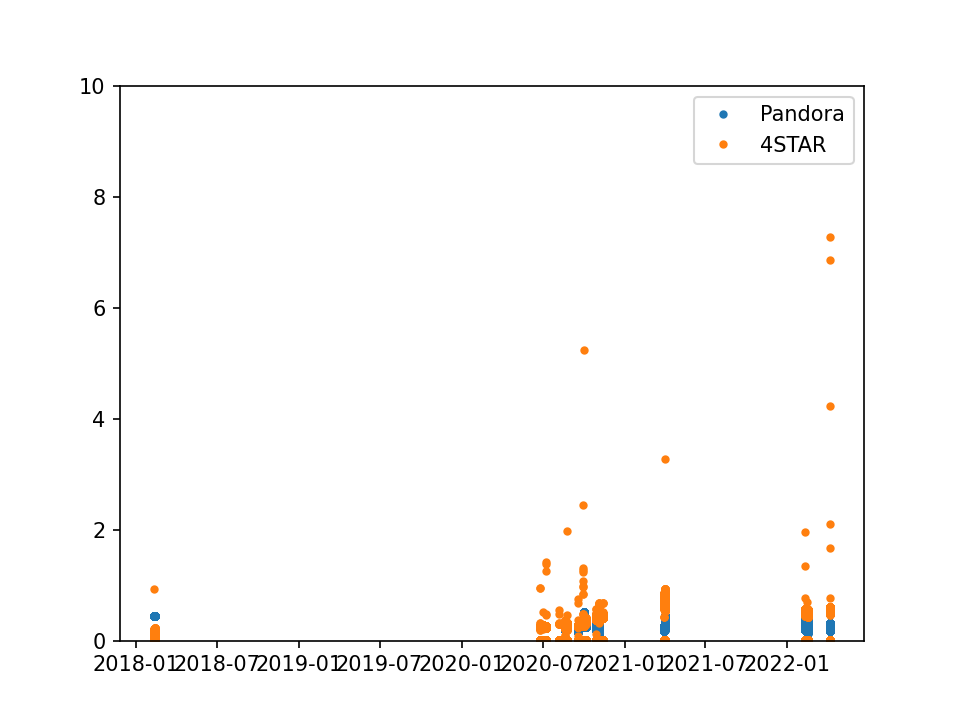

In [44]:
plt.figure()
plt.plot(fullpdn['datetime'],fullpdn['no2_du'],'.',label='Pandora')
plt.plot(fullpdn['datetime'],fullpdn['no2DU'],'.',label='4STAR')
plt.ylim(0,10)
plt.legend()

In [54]:
fln = np.isfinite(fullpdn['no2_du']) & np.isfinite(fullpdn['no2DU'])

<IPython.core.display.Javascript object>


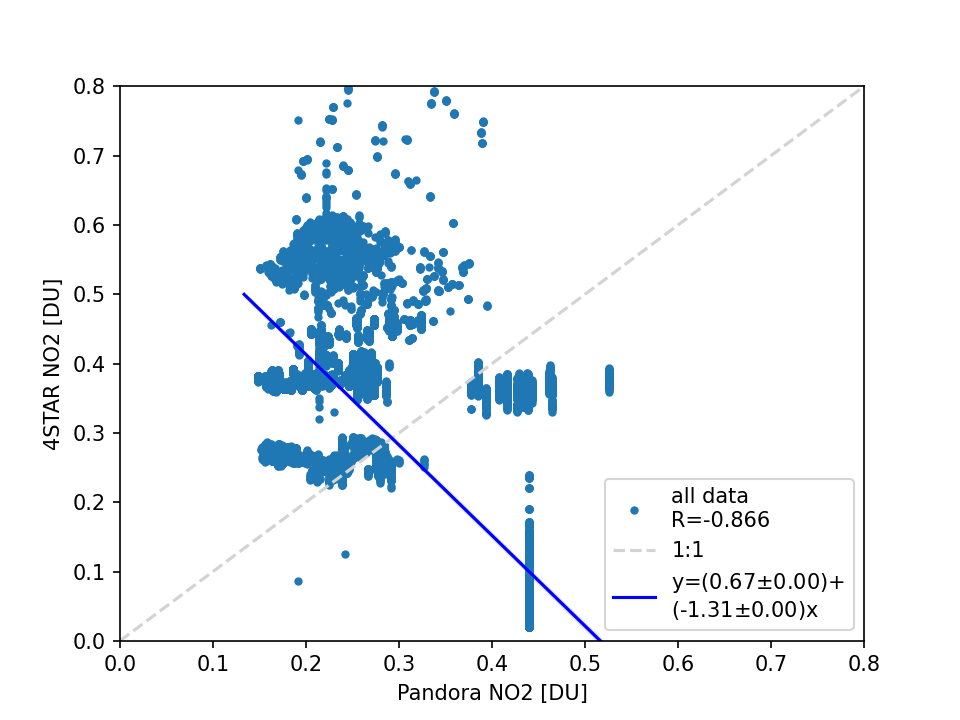

(0.0, 0.8)

In [57]:
plt.figure()
plt.plot(fullpdn['no2_du'],fullpdn['no2DU'],'.',
         label='all data\nR={:1.3f}'.format(np.corrcoef(fullpdn['no2_du'][fln],fullpdn['no2DU'][fln])[0,1]))
plt.plot([0,10],[0,10],'--',color='lightgrey',label='1:1')
pu.plot_lin(fullpdn['no2_du'],fullpdn['no2DU'])
plt.legend()
plt.ylabel('4STAR NO2 [DU]')
plt.xlabel('Pandora NO2 [DU]')
plt.ylim(0,0.8)
plt.xlim(0,0.8)

#plt.savefig(fp+'Winter_2022/plots/4STAR_to_Pandora_NO2.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


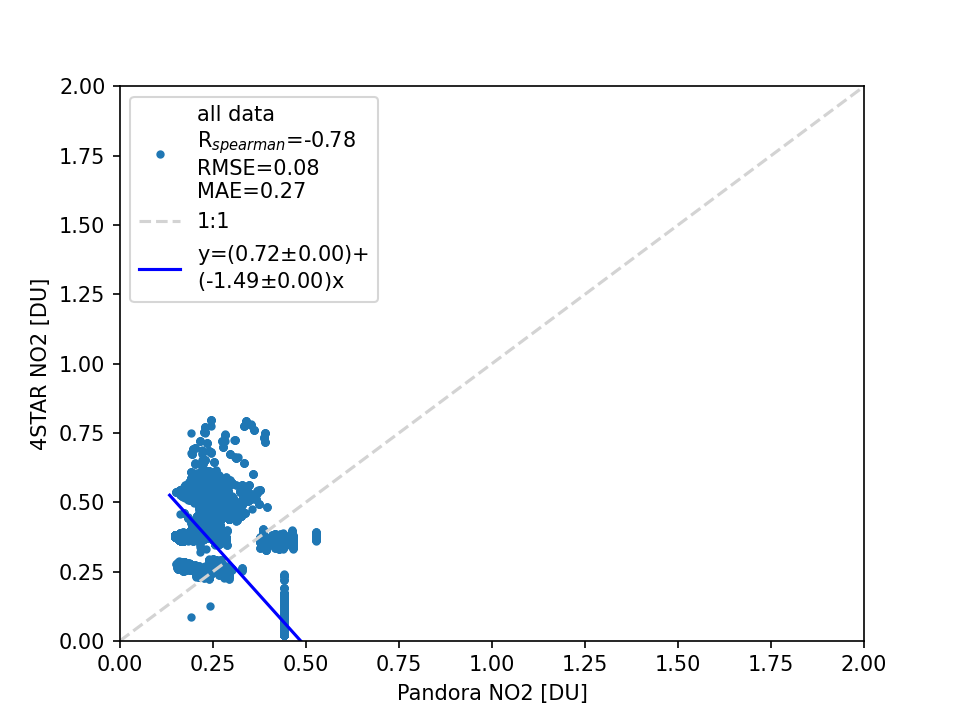

(0.0, 2.0)

In [55]:
plt.figure()
plt.plot(fullpdn['no2_du'],fullpdn['no2DU'],'.',
         label='all data\n'+pu.stats_label(fullpdn['no2_du'],fullpdn['no2DU']))
plt.plot([0,10],[0,10],'--',color='lightgrey',label='1:1')
pu.plot_lin(fullpdn['no2_du'],fullpdn['no2DU'],x_err=fullpdn['unc_no2_du'],y_err=fullpdn['no2resiDU'],use_method='york')
plt.legend()
plt.ylabel('4STAR NO2 [DU]')
plt.xlabel('Pandora NO2 [DU]')
plt.ylim(0,2)
plt.xlim(0,2)

#plt.savefig(fp+'Winter_2022/plots/4STAR_to_Pandora_NO2.png',dpi=600,transparent=True)

# Get the darks for each 4STAR file

In [19]:
files

['/data/sunsat/rooftop//gas_summary_v3/4STAR_20200624_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20200630_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20200701_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20200708_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20200805_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20200819_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20200824_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20200929_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20201001_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20201006_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20201027_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20201104_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20201112_gas_summary.mat',
 '/data/sunsat/rooftop//gas_summary_v3/4STAR_20210330_gas_summar

In [20]:
daystrs = [fi.split('/')[-1].split('_')[1] for fi in files]

In [55]:
darks = []
for d in daystrs:
    files_starsun = glob.glob(fp + '/**/data_processed/starsuns/4STAR_{}starsun.mat'.format(d), recursive=True)
    tmp = hs.loadmat(files_starsun[0],variable_names=['t','dark','w'])
    tmp['time'] = lu.mat2py_time(tmp['t'])
    darks.append(tmp)

In [56]:
darks[0]

{'t': array([[737966.68722999],
        [737966.68725332],
        [737966.68726598],
        ...,
        [737966.90867096],
        [737966.90869755],
        [737966.90871726]]),
 'dark': array([[    0.      ,   186.3     ,   202.2     , ...,    25.      ,
           -20.      , -1279.      ],
        [    0.      ,   183.8     ,   201.      , ...,    36.      ,
           -21.      , -1268.      ],
        [    0.      ,   185.2     ,   201.7     , ...,    24.      ,
           -19.      , -1271.      ],
        ...,
        [    0.      ,   468.48334 ,   483.41666 , ...,    40.166668,
           -31.333334, -1261.5     ],
        [    0.      ,   468.48334 ,   483.41666 , ...,    40.166668,
           -31.333334, -1261.5     ],
        [    0.      ,   468.      ,   483.3     , ...,    39.      ,
           -31.      , -1258.      ]], dtype=float32),
 'w': array([[0.1719711 , 0.17277901, 0.17358692, ..., 1.7018397 , 1.7030145 ,
         1.70301   ]], dtype=float32),
 'time': array

In [60]:
darks[0]['dark'].shape

(17375, 1556)

In [58]:
i_650 = np.argmin(abs(darks[0]['w']-0.65))
i_490 = np.argmin(abs(darks[0]['w']-0.46))
i_460 = np.argmin(abs(darks[0]['w']-0.49))

In [61]:
dark_650 = []
dark_460 = []
dark_490 = []
for d in darks:
    dark_650.append(d['dark'][:,i_650])
    dark_460.append(d['dark'][:,i_460])
    dark_490.append(d['dark'][:,i_490])
    

<IPython.core.display.Javascript object>


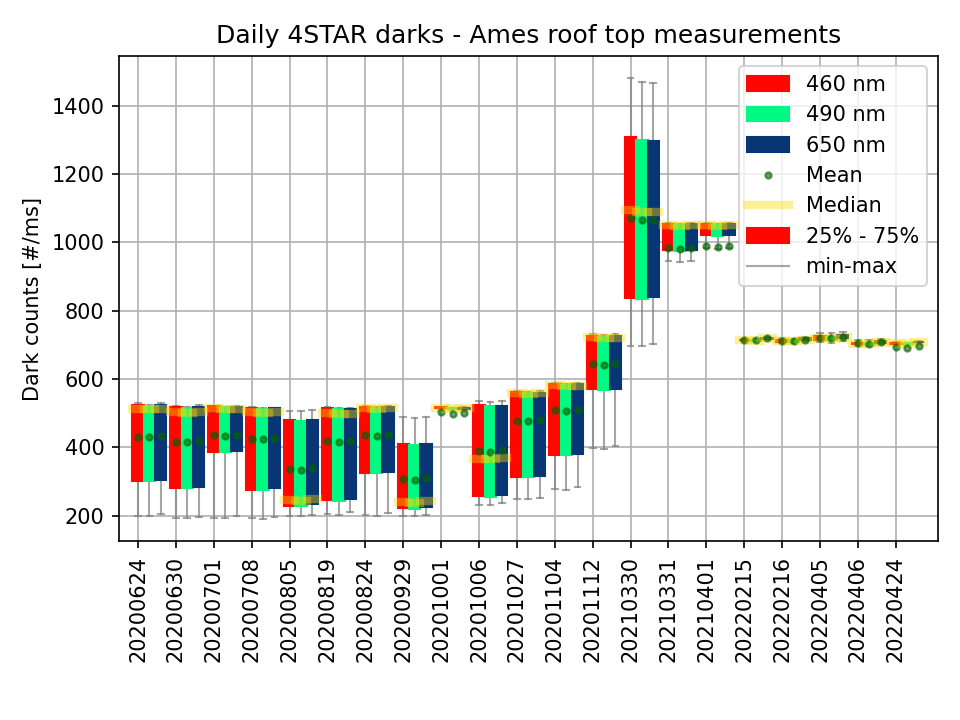

In [65]:
plt.figure()
gr = plt.cm.autumn_r
dummy_n = np.arange(0,len(dark_460))*0.0+200.0
dummy_n[-1] = 205.0
bp = plt.boxplot(dark_460,vert=True,positions=np.arange(0,len(dark_460)),
                   showfliers=False,widths=0.3,showmeans=True,patch_artist=True)
pu.set_box_whisker_color(gr,bp,dummy_n,whisker_color='grey')
grp = plt.cm.winter
bpp = plt.boxplot(dark_490,vert=True,positions=np.arange(0,len(dark_490))+0.3,
                   showfliers=False,widths=0.3,showmeans=True,patch_artist=True)
pu.set_box_whisker_color(grp,bpp,dummy_n,whisker_color='grey')
grp = plt.cm.Blues
bpb = plt.boxplot(dark_650,vert=True,positions=np.arange(0,len(dark_650))+0.6,
                   showfliers=False,widths=0.3,showmeans=True,patch_artist=True)
pu.set_box_whisker_color(grp,bpb,dummy_n,whisker_color='grey')
plt.gca().set_xticks(np.arange(0,len(dark_650)))
plt.gca().set_xticklabels(daystrs,rotation=90)
plt.grid()
plt.ylabel('Dark counts [#/ms]')
plt.title('Daily 4STAR darks - Ames roof top measurements')
plt.legend([bp['boxes'][0],bpp['boxes'][0],bpb['boxes'][0],bp['means'][0],bp['medians'][0],bp['boxes'][0],bp['whiskers'][0]],
               ['460 nm','490 nm','650 nm','Mean','Median','25% - 75%','min-max'],
               frameon=True,loc=0,numpoints=1)
plt.tight_layout(rect=(0,0.05,1,1))
plt.savefig(fp + '/daily_4STAR_darks_{}.png',dpi=600,transparent=True)

## Compare darks to NO2

In [69]:
dark_460_TS = np.hstack(dark_460)

In [83]:
no2_star_all = []
no2resi_star_all = []
for g in gas:
    no2_star_all.append(gas[g]['no2DU'])
    no2resi_star_all.append(gas[g]['no2resiDU'])
no2_star_TS = np.vstack(no2_star_all)
no2resi_star_TS = np.vstack(no2resi_star_all)

<IPython.core.display.Javascript object>


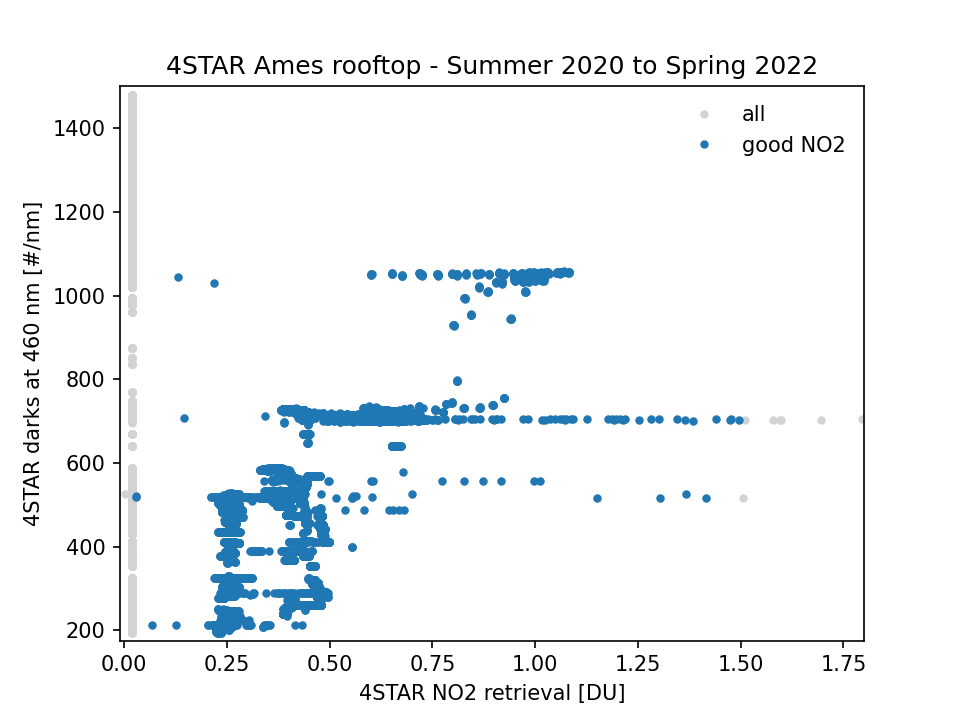

In [93]:
plt.figure()
plt.plot(no2_star_TS,dark_460_TS,'.',c='lightgrey',label='all')
igood = (no2_star_TS[:,0] > 0.025) & (no2resi_star_TS[:,0]<0.05) & (no2_star_TS[:,0] < 1.5)
plt.plot(no2_star_TS[igood],dark_460_TS[igood],'.',c='tab:blue',label='good NO2')
plt.legend(frameon=False)
plt.xlim([-0.01,1.8])
plt.ylim([175,1500])
plt.ylabel('4STAR darks at 460 nm [#/nm]')
plt.xlabel('4STAR NO2 retrieval [DU]')
plt.title('4STAR Ames rooftop - Summer 2020 to Spring 2022')
plt.savefig(fp + '/4STAR_darks_vs_NO2_{}.png'.format(vv),dpi=600,transparent=True)